
Machine Learning Analysis with Venue Review Data in Calgary, Canada
-------------------------------



I will analyse a dataset that contains review data of different venues in the city of Calgary,
Canada.

### 3.1 Format of Data

The variables contained in the dataset provided in the `Calgary.csv` file, are:

* `business_id`, unique identifier of the premise
* `Name`, name of premise
* `latitude`, `longitude`, i.e. the locational attributes of the venue. <br/>
* `review_count` or the number of reviews the venue has been given<br/>
* `categories` general category of establishment that a venue falls under 
(Note: this variable is rather messy and might needs some cleaning/consolidation to be usable)<br/>
* `hours` or the opening hours of the venue <br/>
* `review_id` unique identifier of the review <br/>
* `user_id` unique identifier of the individual who left the review<br/>
* `stars_y` individual ratings of the venue<br/>
* `useful`, `funny`, `cool`, i.e. tags that the user attached to the review<br/>
* `text`, text of the review <br/>
* `date` i.e. the date of the review<br/>

### 3.2.1 Loading and cleaning the textual dataset


#### 3.2.1.1 Loading the data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import seaborn as sns
import time
import geopandas as gpd
import folium
import re
from geopy.distance import geodesic
from math import radians


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, confusion_matrix, recall_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score




from scipy.sparse import hstack


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
  


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

We load the data frame.

In [6]:
data = pd.read_csv('Calgary.csv')

#### 3.2.1.2 Positive/Negative Variable


We create a column that stores the polarity score variable with two categories (1 = positive (4+ stars); 0 = negative (3 or less stars). Even though this step is not mentioned until 3.2.2, it is interesting to see the distribution of this variable alongside the other variables in the next step.

In [7]:
data['positive'] = data['stars_y'].apply(lambda x: 1 if x >= 4 else 0)
data

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive
0,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",pltqT0DnejbWN-K32BD1Fg,v6zuRbp5jjHroawRiv9IhQ,5.0,1,0,0,David came in the spring to give me an estimat...,2017-08-16 01:10:52,1
1,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",8Iaf1YXNjo3zPd6-uLSJhg,UkL35C-EXA_yje4HeNINeQ,5.0,0,0,0,Chinook Landscaping is a Company that I would ...,2014-06-15 21:09:06,1
2,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",fTU0yYLj78NJftEKah-woQ,CXhdG2DP0aplOZPZtNFobw,5.0,0,0,0,Chinook Landscaping is tops in my book\nI was ...,2013-08-22 22:10:38,1
3,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",2SGfqlKDjuFpXZ7LjdNJSQ,siNu6MF02MSMnoyPkaxZyg,5.0,5,0,0,If you are looking for a supplier of games tab...,2009-06-29 02:20:25,1
4,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",5RfnOMsGcQ26EoXlteFOyw,-InhDRRVG7wrwsgAUvN4Qw,5.0,6,3,3,"SML is now a personal wet dream of mine, the e...",2009-12-03 17:29:51,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",pd7i8sxkMfbjdWR926nz8Q,zYLF37lcx2MPIHZVJjahBA,5.0,1,1,0,"I rarely post reviews, but wanted to express h...",2016-08-18 14:19:05,1
82178,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",Uu4txscaQB25tF5kuG4gkg,rlY-ah6vhTHiRkJMEtDJ-g,5.0,1,0,0,I used Martin's Pest Control for an under-conc...,2015-10-17 23:16:52,1
82179,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",kooH5UmJ5k-8USDe03jI9Q,Id5k4kNeblkyQSuteVURGQ,1.0,6,0,0,"This company came into my home, 'inspected' th...",2011-09-09 20:22:04,0
82180,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",2SUoFTckEOdGd1V7GpIvrg,grsdpOuwSdwN3ndafhfa9Q,1.0,3,0,0,I would never recommend them to anyone. I pur...,2013-08-02 07:21:12,0


#### 3.2.1.3 Describing numeric variables and checking distribution of these attributes


We describe the numeric variables in the data: Latitude, longitude, review count, stars, useful, funny, cool, and the recently created 'positive'.

In [4]:
data.describe()

,latitude,longitude,review_count,stars_y,useful,funny,cool,positive
count,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000
mean,51.042724,-114.070648,61.995254,3.618639,1.293203,0.391083,0.382578,0.640262
std,0.051552,0.053040,77.290191,1.424214,2.830347,1.306604,1.171075,0.479926
min,50.865169,-114.379523,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,51.033200,-114.086896,13.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,51.044727,-114.070254,36.000000,4.000000,0.000000,0.000000,0.000000,1.000000
75%,51.066428,-114.053056,78.000000,5.000000,2.000000,0.000000,0.000000,1.000000
max,51.207540,-113.714140,512.000000,5.000000,104.000000,59.000000,69.000000,1.000000


We plot these to check their distributions

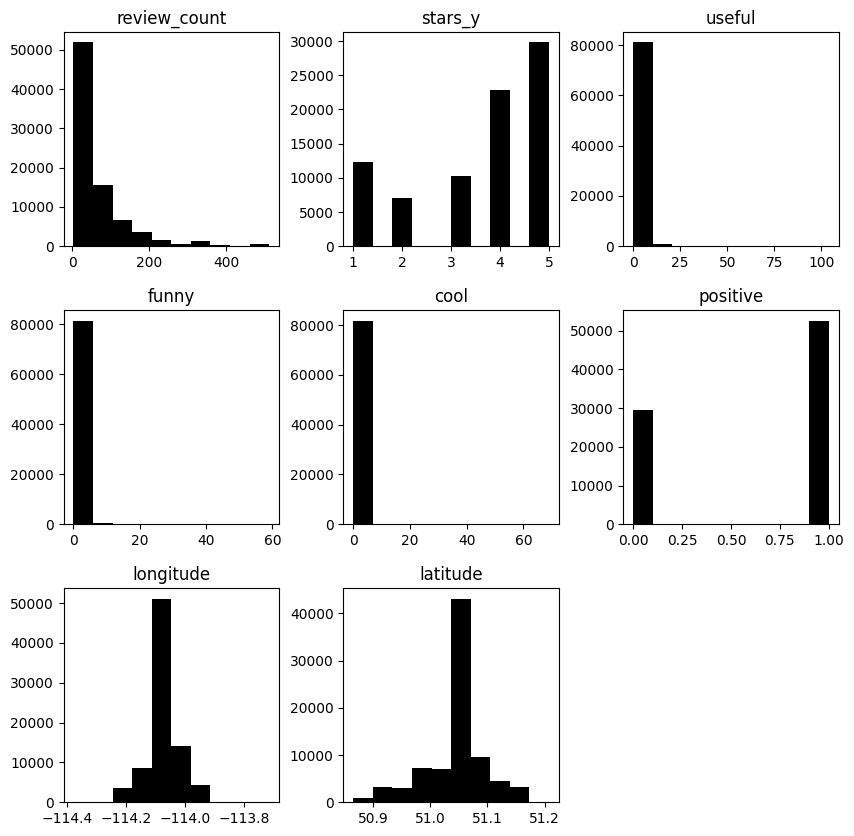

In [5]:
numeric_cols = ['review_count','stars_y', 'useful', 'funny', 'cool', 'positive', 'longitude', 'latitude']
numeric_data = data[numeric_cols]
numeric_data.hist(figsize=(10,10),color='black',grid=False)
#plt.axis(False)
plt.show()

We build a correlation heatmap to dicover the variables further. 

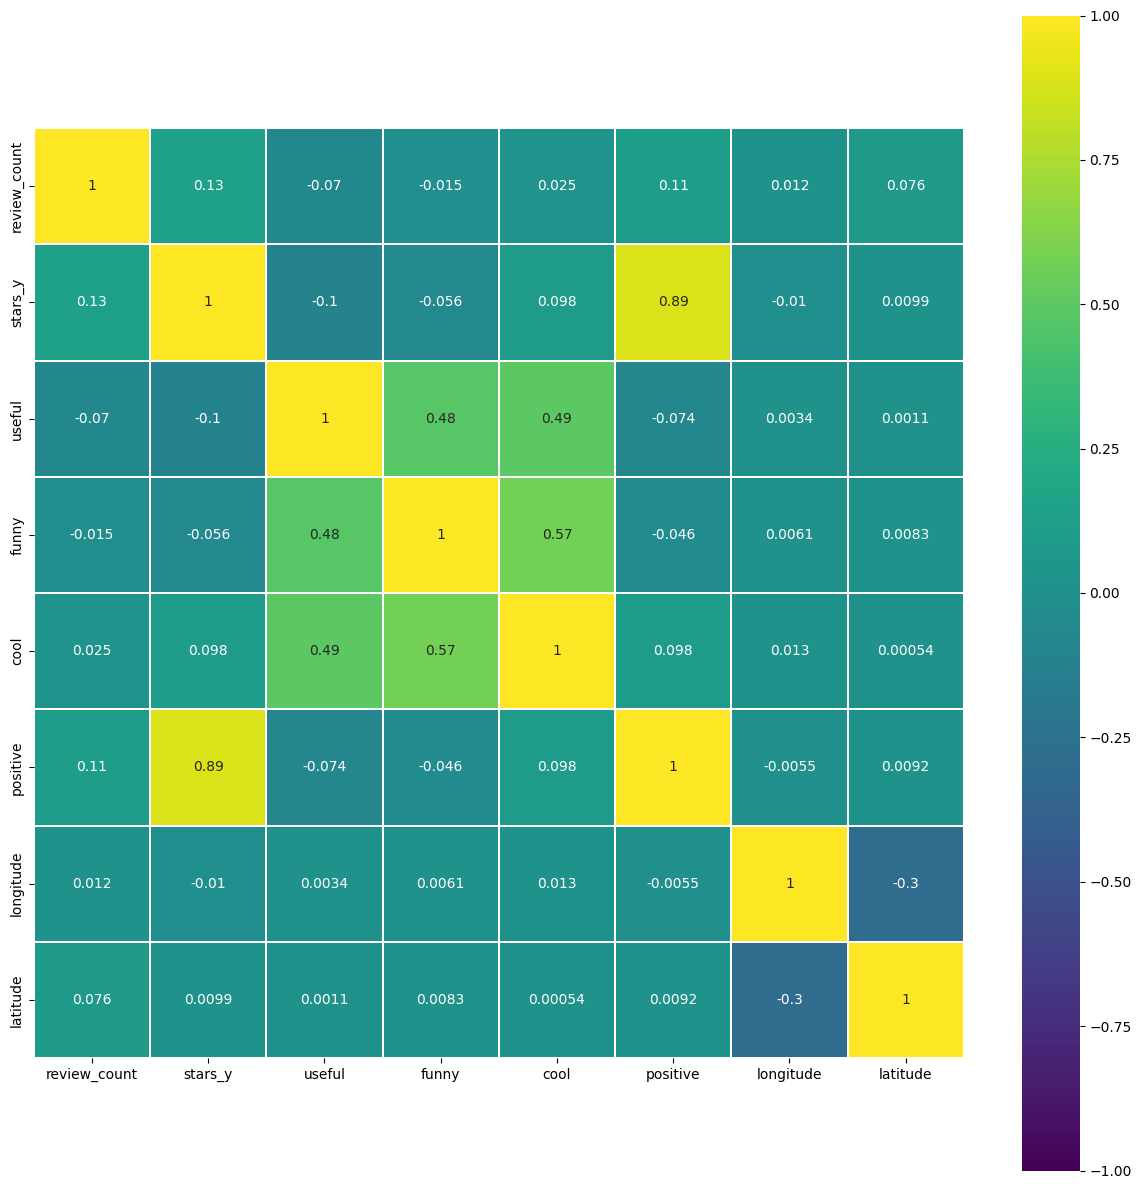

In [6]:
corr = data[numeric_data.columns].corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, center=0,cmap=plt.get_cmap('viridis'),
            square=True, linewidths=.05, annot=True, vmin=-1, vmax=1,ax=ax) 
plt.show()

#### 3.2.1.4 Discovering categorical variables


In [7]:
categorical_data = data.select_dtypes(include=[object])
categorical_data.columns

Index(['business_id', 'name', 'categories', 'hours', 'review_id', 'user_id',
       'text', 'date'],
      dtype='object')

We observe how business categories are inputted in the data for our future analysis

#### 3.2.1.5 Pre-process text reviews

We define a function to pre-process our text column. 
This function 
* removes punctuation and numbers, 
* turns words into lowercase, 
* removes non-English characters
* tokenizes them, 
* removes stop words, 
* lemmatizes the tokens
* joins the tokens back into a string.
In the end, we join this new pre-processed text as a new column to our data.

In [8]:
lemmatizer = WordNetLemmatizer()


def without_punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))

# Several reviews have textisms of common stop words but without punctuation
stop_words = set(stopwords.words('english'))
stopWordsWithoutPunctuation = [without_punctuation(stopWord) for stopWord in stop_words]
stop_words.update(stopWordsWithoutPunctuation)

# Define a function for text preprocessing
def preprocess_text(text):
    #Lowercase
    text = text.lower()
    text = re.sub("([^\x00-\x7F])+"," ",text)
    # Tokenize the text
    tokens = text.split()
    
    # filter stop words, remove punctuation
    tokens = [without_punctuation(token) for token in tokens if token not in stop_words]
    
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
   
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

data['preprocessed_text'] = data['text'].apply(preprocess_text)

We remove the rows that have empty 'preprocessed_text' cells after our treatment for it to not affect our analysis. 

In [9]:
# remove rows of only stop words
data = data[data['preprocessed_text'] != '']
# verify that there's none remaining
(data['preprocessed_text'] == '').sum()

0

### 3.2.2 Build a supervised learning for text analysis


#### 3.2.2.1 Models with only text 

We are definig the vectorizer that is going to be used in the model. Since we already have a column of cleaned data, we do not include a text cleaning process into this vectoriser.

This vectorizer removes the words that occur in more that 95% of the observations and less than 1% of the observations. This helps us remove words are too frequent too infrequent to be relevant to help our model classify observations.

We visualise the output of this vectorizer. 

In [10]:
text_column = data['preprocessed_text'].tolist()
#turns text data into feature vectors
vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=0.01)

#check how it looks
text_column_transformed = vectorizer.fit_transform(data.text)
pd.DataFrame(text_column_transformed.toarray(),columns=[vectorizer.get_feature_names_out()])

,10,100,12,15,17th,20,25,30,35,40,...,wrap,write,wrong,year,yelp,yes,yet,you,young,yummy
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
82174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


However, there can be an even better way to vectorize our text data. We define a term frequency - inverse document frequency vectorizer. This improves the accuracy of our models because it takes into the length of the document into account when considering term frequency.

In [13]:
#turns text data into feature vectors
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, 
                                    min_df=0.01)

#check how it looks
text_column_tfidf = tfidf_vectorizer.fit_transform(data.text)
pd.DataFrame(text_column_tfidf.toarray(),columns=[tfidf_vectorizer.get_feature_names_out()])
    

,00,10,100,11,12,15,17th,20,25,30,...,year,years,yelp,yes,yet,you,young,your,yourself,yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.098962,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.177545,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.072785,0.0,0.059175,0.0,0.175119,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.058239,0.0,0.000000,0.0,0.0
82174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
82175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
82176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


We test and train split our data. Our predictor is the preprocessed text and our target categories are positive and negative.

We apply a 20% test size. Then, we apply our vectorizer to the text train and text test sets. 

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, data.positive, 
                                                      test_size = 0.20, random_state = 1)
x_train_vectors = tfidf_vectorizer.transform(x_train.preprocessed_text)
x_test_vectors = tfidf_vectorizer.transform(x_test.preprocessed_text)


##### 3.2.2.1.a Defining Useful Functions

For each type of model, we'll do a grid search (with cross-validation using the training data) to select hyperparameters, then train the best model on the training data and report various statistics of the test data (f1 score, accuracy score, mse, r2 and recall). We'll perform cross validation and report the accuracy and standard deviation as well for each model.

In [38]:
def showScores(y_test, y_pred):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    print(f"Test Accuracy={accuracy:.4f}, MSE={mse:.4f}, r2={r2:.4f}, f1={f1:.4f}, recall={recall:.4f}")
    
    #creates a grid to plot on
    f, ax = plt.subplots(figsize=(7, 5))
    # plots confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred),annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.show()

def gridSearchCvAndScore(model, params, x_train, y_train, x_test, y_test, cv=5, **kwargs):
    '''
    Selects hyperparameters based on grid search with cross-validation.
    Reports statistics of the chosen model/hyperparameters after training on all of the training data, 
    then predicting on the test data.
    Returns the grid search results (from which .best_estimator_ is the chosen model) for any further analysis
    kwargs is there to e.g. adjust how verbose the grid search is
    '''
    # GridSearchCV does a deterministic split of data for cross-validation, so results are reproducible.
    # refit=True is the default, and means best_estimator_ returns an estimator retrained on the whole training data,
    # after the best parameters have been selected via cross-validation for each choice of parameters.
    grid_search = GridSearchCV(model, params, cv=cv, scoring='accuracy', refit=True, n_jobs=8)

    # cross-validation grid search over the training data
    grid_search.fit(x_train, y_train)
    
    # print some info about the best model selected
    # Score is accuracy, see above
    print(f"Best model's params: {grid_search.best_params_}")
    
    # now only look at the best one - already trained on the entirety of the test data
    model = grid_search.best_estimator_
    
    # also remember how much variation we saw during cross-validation for the chosen model, to indicate overfitting
    mean_fold_score =  grid_search.best_score_
    std_fold_score  = grid_search.cv_results_["std_test_score"][grid_search.best_index_]
    print(f"During cross-validation, model had mean accuracy={mean_fold_score:.4f}, std={std_fold_score:.6f}")
    
    # Now evaluate on the test data
    y_pred = model.predict(x_test)
    showScores(y_test, y_pred)
    
    return grid_search

Finally, we define a function to print the permutation importance of added non-categorical values for section 3.2.2.2.

In [45]:

def permImp(model, x_train_vectors, y_train, feature_cols):
    '''
    We compute permutation importance based on just one training/validation split, for the model already
    chosen using grid search/cross validation, and retrained for this fold.
    We could take the average of the results across each fold, but assume they will be similar to save computation time.
    '''
    x_train, x_validate, y_train, y_validate = train_test_split(x_train_vectors, y_train, test_size=0.2)

    model.fit(x_train, y_train)

    # calculate the permutation importance of the new features
    result = permutation_importance(model, x_validate.toarray(), y_validate, n_repeats=10, random_state=0, n_jobs=8)
    for i in result.importances_mean.argsort()[::-1]:
        if i >= len(result.importances_mean.argsort()) - len(feature_cols):
            print(f"{feature_cols[i-(len(result.importances_mean.argsort())-len(feature_cols))]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

We fit our classifiers:
* Naive Bayes Classifier
* Logistic Regression Classifier
* Random Forest Classifier 

Disclaimer: Random Forest Classifier may take more time than the others. 

##### 3.2.2.1.b Naive Bayesian Model

For Naive Bayes, we don't input any choice of hyperparameters to our analysis. 

Best model's params: {}
During cross-validation, model had mean accuracy=0.8190, std=0.003251
Test Accuracy=0.8229, MSE=0.1771, r2=0.2309, f1=0.7917, recall=0.7754


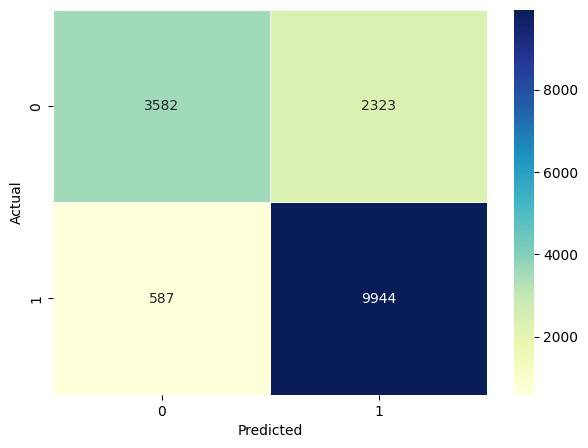

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=8, param_grid={},
             scoring='accuracy')

In [17]:
# Naive Bayes Classifier
clf = MultinomialNB()#

# Nothing to grid search over
gridSearchCvAndScore(clf, {}, x_train_vectors, y_train, x_test_vectors, y_test)

##### 3.2.2.1.c Logistic Regression Classifier Model

We conduct a grid search to determine the best 'C' hyperparameter for our logistic model. C represents inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization [1].

Best model's params: {'C': 1}
During cross-validation, model had mean accuracy=0.8710, std=0.002969
Test Accuracy=0.8646, MSE=0.1354, r2=0.4117, f1=0.8511, recall=0.8471


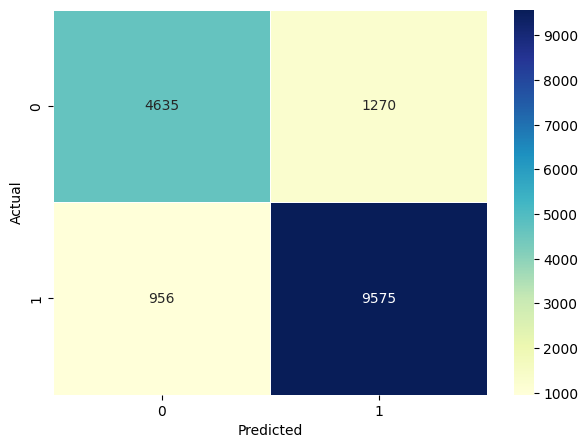

In [18]:
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# define the range of penalty parameter values to explore
param_grid = {'C': [0.01, 0.1, 1, 10]}
    
    
grid_search = gridSearchCvAndScore(clf_logistic, param_grid, x_train_vectors, y_train, x_test_vectors, y_test)

To see how each C value performed, we plot the accuracy and corresponding C values. 

Text(0, 0.5, 'accuracy')

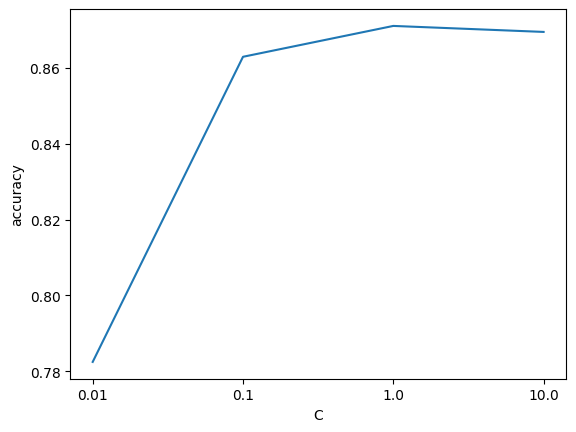

In [19]:
results = grid_search.cv_results_
x_data = results["param_C"].data.astype(float)
plt.plot(results["mean_test_score"])
plt.xticks(np.arange(len(x_data)), x_data) # not worth dealing with log scales etc, so just use natural scale
plt.xlabel("C")
plt.ylabel("accuracy")


##### 3.2.2.1.d Random Forest Classifier Model

We then fit a Random Forest Classifier model. The reader should note that it takes significantly longer than the other models to run. 

We run a grid search for our Random Forest Model regarding max depth and n estimators hyperparameters. 

Best model's params: {'max_depth': 100, 'n_estimators': 300}
During cross-validation, model had mean accuracy=0.8468, std=0.001417
Test Accuracy=0.8489, MSE=0.1511, r2=0.3435, f1=0.8292, recall=0.8183


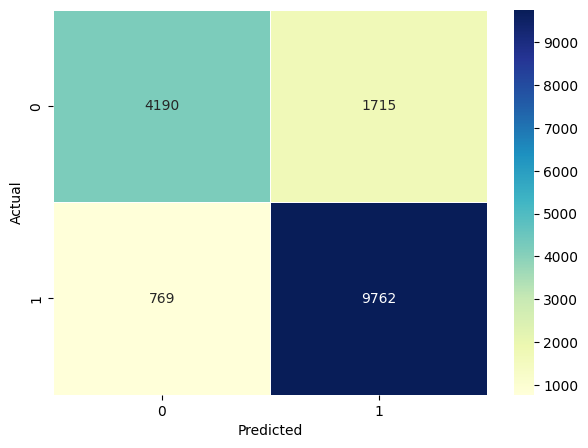

In [22]:
param_grid = {
    'max_depth': [10, 30, 60, 100],
    'n_estimators': [10, 50, 100, 200, 300]
}

model = RandomForestClassifier()

grid_search = gridSearchCvAndScore(model, param_grid, x_train_vectors, y_train, x_test_vectors, y_test, cv=3, verbose=3)

We create a pivot table to visualise the performance of the parameters.

In [25]:
#create pivot table
searchResults = pd.DataFrame(grid_search.cv_results_)
grid_reset = searchResults.groupby(['param_max_depth', 'param_n_estimators'])["mean_test_score"].mean().reset_index()
grid_reset.columns = ['param_max_depth', 'param_n_estimators', 'mean_test_score']
grid_pivot = grid_reset.pivot(index='param_max_depth', columns='param_n_estimators')
grid_pivot

mean_test_score                                        
param_n_estimators             10        50        100       200       300
param_max_depth                                                           
10                        0.746463  0.751605  0.754373  0.754145  0.753248
30                        0.805315  0.824770  0.826762  0.828679  0.828283
60                        0.813300  0.837410  0.841502  0.843357  0.843844
100                       0.814669  0.841532  0.844711  0.845913  0.846795

We plot the parameters and their performance to see which one works better. 

Text(0, 0.5, 'max_depth')

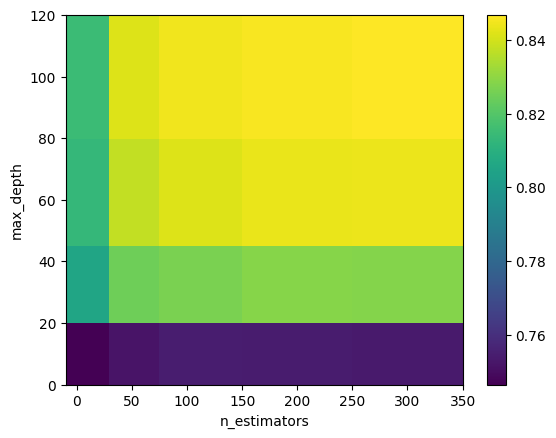

In [26]:
#plot 3D 
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

plt.pcolor(x, y, z)
plt.colorbar()
plt.xlabel("n_estimators")
plt.ylabel("max_depth")

#### 3.2.2.2 Models with text and non-text features

##### 3.2.2.2.a Sentiment Analysis (Lexicon Based) as a feature

As an experimental feature, we run a lexicon based sentiment analysis of our tokenized text cells and store the scores as a new column to use in our model. 

In [32]:
sid = SentimentIntensityAnalyzer()

data['sentiment_score'] = data['preprocessed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])


/var/folders/ph/c8qrnk695bg39ggsrrps3r2h0000gn/T/ipykernel_45723/3275819504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment_score'] = data['preprocessed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])


In [45]:
data

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive,preprocessed_text,sentiment_score
0,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",pltqT0DnejbWN-K32BD1Fg,v6zuRbp5jjHroawRiv9IhQ,5.0,1,0,0,David came in the spring to give me an estimat...,2017-08-16 01:10:52,1,david came spring give estimate redoing centre...,0.8807
1,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",8Iaf1YXNjo3zPd6-uLSJhg,UkL35C-EXA_yje4HeNINeQ,5.0,0,0,0,Chinook Landscaping is a Company that I would ...,2014-06-15 21:09:06,1,chinook landscaping company would recommend ev...,0.9613
2,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",fTU0yYLj78NJftEKah-woQ,CXhdG2DP0aplOZPZtNFobw,5.0,0,0,0,Chinook Landscaping is tops in my book\nI was ...,2013-08-22 22:10:38,1,chinook landscaping top book extremely pleased...,0.9945
3,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",2SGfqlKDjuFpXZ7LjdNJSQ,siNu6MF02MSMnoyPkaxZyg,5.0,5,0,0,If you are looking for a supplier of games tab...,2009-06-29 02:20:25,1,looking supplier game table pool cue accessory...,0.9738
4,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",5RfnOMsGcQ26EoXlteFOyw,-InhDRRVG7wrwsgAUvN4Qw,5.0,6,3,3,"SML is now a personal wet dream of mine, the e...",2009-12-03 17:29:51,1,sml personal wet dream mine exterior deceiving...,0.9843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",pd7i8sxkMfbjdWR926nz8Q,zYLF37lcx2MPIHZVJjahBA,5.0,1,1,0,"I rarely post reviews, but wanted to express h...",2016-08-18 14:19:05,1,rarely post review wanted express impressed cu...,0.8807
82178,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",Uu4txscaQB25tF5kuG4gkg,rlY-ah6vhTHiRkJMEtDJ-g,5.0,1,0,0,I used Martin's Pest Control for an under-conc...,2015-10-17 23:16:52,1,used martin pest control underconcrete frontst...,-0.5574
82179,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",kooH5UmJ5k-8USDe03jI9Q,Id5k4kNeblkyQSuteVURGQ,1.0,6,0,0,"This company came into my home, 'inspected' th...",2011-09-09 20:22:04,0,company came home inspected place wrote report...,-0.9371
82180,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",2SUoFTckEOdGd1V7GpIvrg,grsdpOuwSdwN3ndafhfa9Q,1.0,3,0,0,I would never recommend them to anyone. I pur...,2013-08-02 07:21:12,0,would never recommend anyone purchased home mo...,-0.8903


We refresh the test and training sets to include the sentiment analsysis.

In [33]:
#refresh the sets so that they would include the sentiment analysis
x_train, x_test, y_train, y_test = train_test_split(data, data.positive, 
                                                      test_size = 0.20, random_state = 1)
x_train_vectors = tfidf_vectorizer.transform(x_train.preprocessed_text)
x_test_vectors = tfidf_vectorizer.transform(x_test.preprocessed_text)


We write a function to add non-text features to add to our model. We will take an iterative approach since features that are used together might influence the importance of the others. First, we will introduce all numeric variables as feature and we will check whether it will improve the model accuracy and other statistics (r2, mse etc.) and whether they have permutation importance. We will evaluate the permutation importance both with the coefficients and the variation. We will remove the features that possibly worsens the model and repeat the process.

We should note that even permutation importance doesn't give us a conclusive result regarding feature importance and a low importance might as well be the result of a bad model specification. 

In [34]:
# Takes a matrix of new features
def addFeatures(x_train_vectors, x_test_vectors, train_features, test_features):
    return (hstack((x_train_vectors, train_features)), 
            hstack((x_test_vectors, test_features)))


feature_cols = ["cool", "funny", "useful", "latitude", "longitude", "review_count", "sentiment_score"]
x_train_vectors, x_test_vectors = addFeatures(x_train_vectors, x_test_vectors,
                                             x_train[feature_cols].to_numpy(), 
                                             x_test[feature_cols].to_numpy())

Logistic regression is the best performing classifier among the three, therefore we use that to compare model outputs before and after adding these new features. 

Best model's params: {'C': 1}
During cross-validation, model had mean accuracy=0.8734, std=0.002568
Test Accuracy=0.8700, MSE=0.1300, r2=0.4352, f1=0.8568, recall=0.8521


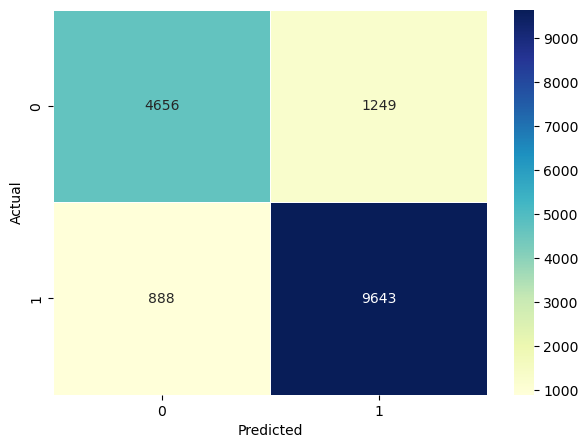

In [40]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# define the range of penalty parameter values to explore
param_grid = {'C': [0.01, 0.1, 1, 10]}
    
    
grid_search = gridSearchCvAndScore(clf_logistic, param_grid, x_train_vectors, y_train, x_test_vectors, y_test)

We check the coefficients of these additional values to assess the feature importance. 

In [68]:
# Train the logistic regression model
clf = grid_search.best_estimator_

# Extract the coefficient estimates for the additional features
additional_features_coef = clf.coef_[0][-len(feature_cols):]

# Create a dataframe to display the feature importance
importance_df = pd.DataFrame({'feature': feature_cols, 
                              'importance': additional_features_coef})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)


           feature  importance
6  sentiment_score    1.535676
3         latitude    0.621024
0             cool    0.354649
4        longitude    0.281669
5     review_count    0.001231
2           useful   -0.048693
1            funny   -0.103563


However, there is also a model agnostic way of assessing feature importance: permutation importance. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature [2].

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model [2].

In [69]:
permImp(clf, x_train_vectors, y_train, feature_cols)

sentiment_score: 0.033 +/- 0.002
cool: 0.007 +/- 0.001
funny: 0.001 +/- 0.000
review_count: 0.001 +/- 0.000
useful: 0.001 +/- 0.001
longitude: 0.000 +/- 0.000
latitude: -0.000 +/- 0.000


We eliminate useful, funny, review count, latitude, longitude since their value is low and/or have a high relative error.

In [41]:
#refresh the sets
x_train, x_test, y_train, y_test = train_test_split(data, data.positive, 
                                                      test_size = 0.20, random_state = 1)
x_train_vectors = tfidf_vectorizer.transform(x_train.preprocessed_text)
x_test_vectors = tfidf_vectorizer.transform(x_test.preprocessed_text)


In [42]:
feature_cols = ["cool", "sentiment_score"]
x_train_vectors, x_test_vectors = addFeatures(x_train_vectors, x_test_vectors,
                                             x_train[feature_cols].to_numpy(), 
                                             x_test[feature_cols].to_numpy())

Best model's params: {'C': 1}
During cross-validation, model had mean accuracy=0.8734, std=0.002568
Test Accuracy=0.8700, MSE=0.1300, r2=0.4352, f1=0.8568, recall=0.8521


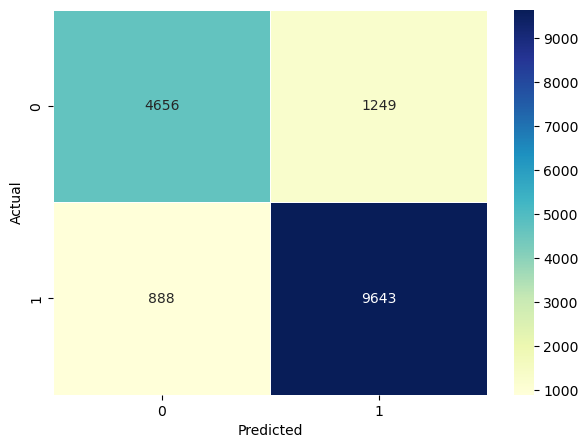

In [43]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)
    
grid_search = gridSearchCvAndScore(clf_logistic, param_grid, x_train_vectors, y_train, x_test_vectors, y_test)

We re-check our permutation importances. 

In [47]:
permImp(grid_search.best_estimator_, x_train_vectors, y_train, feature_cols)

sentiment_score: 0.032 +/- 0.002
cool: 0.003 +/- 0.000


#### 3.2.2.2.b Models applied on subset of Vietnamese restaurants

In [74]:
categories_list = data['categories'].tolist()
cat = pd.DataFrame(categories_list, columns=['categories'])

#number of unique categories
print(len(set(categories_list)))



3861


There are 3861 unique "bunch" of categories in this data. We note that this doesn't mean that there are 3861 different category attributes but means that there are 3861 unique combination of these categories.

In [75]:
value_counts = cat.value_counts().head(10).reset_index(name="count")
value_counts

,categories,count
0,"Restaurants, Breakfast & Brunch",1085
1,"Vietnamese, Restaurants",912
2,"Restaurants, Vietnamese",729
3,"Restaurants, Pizza",653
4,"Pizza, Restaurants",469
5,"Sushi Bars, Japanese, Restaurants",463
6,"Restaurants, Steakhouses",459
7,"Canadian (New), Restaurants",435
8,"Chinese, Restaurants",399
9,"Italian, Restaurants",398


Vietnamise restaurants, under two differently ordered but same categories, are the most frequently mentioned (1641 times) category. We subset them to apply the model.

In [48]:
viet = data[data['categories'].isin(['Vietnamese, Restaurants', 'Restaurants, Vietnamese'])]
viet

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive,preprocessed_text,sentiment_score
1673,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",38C7g-G4tlXTzUUYCebgBw,uJTi6gG31LQw1Im5KEu2VQ,3.0,0,1,0,I am really disappointed with the changes to t...,2018-10-03 16:52:33,0,really disappointed change new menu loved chi ...,0.8228
1674,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",GY9hfBvLNV6trl-TdaTmeQ,1mM1SMzqdHxucYUIUFisNw,4.0,1,1,0,My friend Loretta was visiting from out of tow...,2018-08-20 17:35:08,1,friend loretta visiting town celiac disease ea...,0.9936
1675,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",9_-A0_TTHcQI1zY7CC6iuA,B--fSz4A7l69QpBkbC3NUg,4.0,1,0,0,Today our group of four decided to lunch at Se...,2019-11-07 22:56:02,1,today group four decided lunch sen vietnamese ...,0.9866
1676,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",RyBXtSUtyQwIcyAd1XNzFw,4w7QW3CmKyMmUvupdZqTWQ,5.0,1,0,0,This place is a great addition to the Deep Sou...,2018-12-29 18:47:56,1,place great addition deep south really lacked ...,0.7906
4397,itCmUwEvcuN0fNVD_6BYGw,Pho Xuan Restaurant,51.061414,-113.980825,19,"Vietnamese, Restaurants","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",RjEKvpSoGZD1nbVyWO6Xow,JsbgKWAXtkFMOAlePsN64A,4.0,0,0,0,"Always enjoy eating here, they serve a great p...",2016-02-14 07:48:25,1,always enjoy eating here serve great pho tai a...,0.9670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80566,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",fFMRWSR0Hwq15E2gI-Q5og,eYDG3xOctso7tgope7AFcA,3.0,0,0,0,My recent craving for Sushi isn't that hard fo...,2011-11-22 08:02:43,0,recent craving sushi hard believe thing happen...,0.6597
80567,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",27EIdA2TRecAjDPJoxZ-xw,Dd2guCgG8aMmJsxByrzMAQ,2.0,1,0,0,Salad rolls = average at best .\n\nVietnamese ...,2016-01-16 21:49:15,0,salad roll average best vietnamese chicken d...,0.8074
80568,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",-A3Z2BWQ2mRMVSNWksp0tg,7kvWyj2W7DLSfLqt0ypBVQ,3.0,1,3,1,"I know, I know ...\nHealth code violations, ro...",2011-02-21 10:34:30,0,know know health code violation rodent etc et...,-0.2215
80569,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",huBBh9IW83KpzxhMA7QfdA,Px45T2VBCVjN-CyTNeR-LA,3.0,0,0,0,I just had eaten this last night and a drink a...,2019-11-02 18:56:19,0,eaten last night drink supposably odd reason s...,-0.4404


We repeat the identical processes we conducted for the whole dataset to fit the model and to add & evaluate features.

In [49]:
x_train_viet, x_test_viet, y_train_viet, y_test_viet = train_test_split(viet, viet.positive, 
                                                      test_size = 0.20, random_state = 1)
x_train_vectors_viet = tfidf_vectorizer.transform(x_train_viet.preprocessed_text)
x_test_vectors_viet = tfidf_vectorizer.transform(x_test_viet.preprocessed_text)


Best model's params: {'C': 10}
During cross-validation, model had mean accuracy=0.8544, std=0.011461
Test Accuracy=0.8237, MSE=0.1763, r2=0.2392, f1=0.8062, recall=0.8009


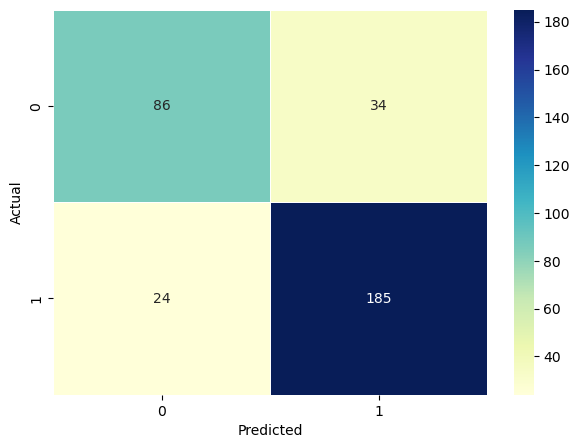

In [50]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)
    
grid_search = gridSearchCvAndScore(clf_logistic, param_grid, x_train_vectors_viet, y_train_viet, x_test_vectors_viet, y_test_viet)

Repeat with additional features

In [51]:
feature_cols = ["cool", "funny", "useful", "latitude","longitude", "sentiment_score"]
x_train_vectors_viet, x_test_vectors_viet = addFeatures(x_train_vectors_viet, x_test_vectors_viet,
                                             x_train_viet[feature_cols].to_numpy(), 
                                             x_test_viet[feature_cols].to_numpy())

Best model's params: {'C': 10}
During cross-validation, model had mean accuracy=0.8491, std=0.021614
Test Accuracy=0.8419, MSE=0.1581, r2=0.3179, f1=0.8262, recall=0.8206


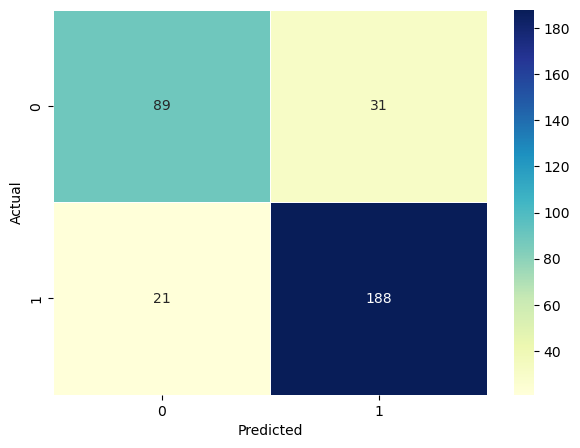

In [52]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)
    
grid_search = gridSearchCvAndScore(clf_logistic, param_grid, x_train_vectors_viet, y_train_viet, x_test_vectors_viet, y_test_viet)

In [53]:
permImp(grid_search.best_estimator_, x_train_vectors_viet, y_train_viet, feature_cols)

sentiment_score: 0.083 +/- 0.015
longitude: 0.003 +/- 0.002
latitude: 0.002 +/- 0.003
useful: 0.001 +/- 0.002
funny: 0.001 +/- 0.004
cool: -0.006 +/- 0.005


In [54]:
#refreshing the set
x_train_viet, x_test_viet, y_train_viet, y_test_viet = train_test_split(viet, viet.positive, 
                                                      test_size = 0.20, random_state = 1)
x_train_vectors_viet = tfidf_vectorizer.transform(x_train_viet.preprocessed_text)
x_test_vectors_viet = tfidf_vectorizer.transform(x_test_viet.preprocessed_text)


In [55]:
feature_cols = ["sentiment_score"]
x_train_vectors_viet, x_test_vectors_viet = addFeatures(x_train_vectors_viet, x_test_vectors_viet,
                                             x_train_viet[feature_cols].to_numpy(), 
                                             x_test_viet[feature_cols].to_numpy())

Best model's params: {'C': 10}
During cross-validation, model had mean accuracy=0.8506, std=0.022235
Test Accuracy=0.8480, MSE=0.1520, r2=0.3441, f1=0.8329, recall=0.8272


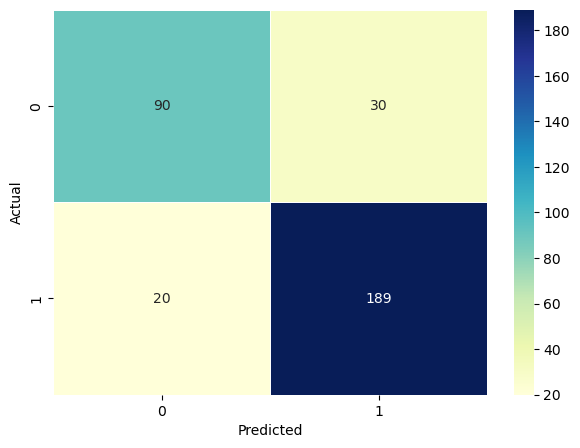

In [56]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)
    
grid_search = gridSearchCvAndScore(clf_logistic, param_grid, x_train_vectors_viet, y_train_viet, x_test_vectors_viet, y_test_viet)

We observe that using only sentiment analysis as a feature improves the model performance.

In [57]:
permImp(grid_search.best_estimator_, x_train_vectors_viet, y_train_viet, feature_cols)

sentiment_score: 0.079 +/- 0.022


### 3.2.3 Geospatial analysis and visualisation of review data


For this task, we subset Chinese restaurants.

In [78]:
search_text = 'Chinese'  
chinese = data[data['categories'].str.contains(search_text, case=False)]
chinese = chinese.drop_duplicates(subset='name', keep='first')
chinese

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive,preprocessed_text,sentiment_score
27,AsgwKCJqyBqdiHdEBqeq3w,Singapore Sam's,51.042296,-114.073224,37,"Chinese, Restaurants, Buffets","{'Monday': '11:30-12:0', 'Tuesday': '11:30-12:...",yqZsA08aY7Vl0NqBOJrddw,ebMJ9QZj8WhjbR5DrCHyZQ,4.0,3,7,4,There is an unfortunate amount of hate-on goin...,2011-11-30 07:11:58,1,unfortunate amount hateon going ol sam ive dec...,0.9819
286,iDSHlWunyWMS02P8kGyHJQ,80 ATE Indo Chinese Fusion House,51.050889,-114.061939,7,"Restaurants, Asian Fusion, Chinese, Indian, Pa...","{'Tuesday': '17:0-22:0', 'Wednesday': '17:0-22...",XcgVpLCGH19Qv-iznrOpIw,vgymWZvyo2gTQs9FnBjqCA,5.0,1,0,0,Good service and friendly hostess .patiently e...,2019-03-13 21:07:55,1,good service friendly hostess patiently explai...,0.8885
293,ShlkehLaKvDXHLDy4IoUhg,Silver City Restaurant,50.930349,-113.971794,5,"Asian Fusion, Restaurants, Cantonese, Chinese","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",l5KfNC3h6QfV3gEf4OUhcg,TDg10c8ivWqnzzmaCKvgIA,4.0,0,0,0,This is a very authentic Asian restaurant. We ...,2019-06-30 19:53:39,1,authentic asian restaurant mixed fried rice be...,0.9081
882,ikFC6OCWC6dUGocTU8kyBQ,Golden Island Restaurant,51.067135,-114.061189,3,"Restaurants, Himalayan/Nepalese, Chinese","{'Monday': '17:0-0:0', 'Wednesday': '17:0-0:0'...",ezwgq_HW_XW0r2RawVgpZQ,v7SaE-eLhvPbDAkvUO-2gQ,5.0,0,0,0,I used to come here as a kid and I remember th...,2018-06-10 02:37:30,1,used come kid remember restaurant building goo...,0.9245
1226,G-0VVUUoNUKT3GrnjZnsaA,Silver Dragon Restaurant,51.050560,-114.062225,107,"Chinese, Restaurants, Specialty Food, Seafood,...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-22:30',...",7Iz2sRzkbZLilg1CGl4wKQ,fD2BIDg2yV5EMeqzFXkvTQ,4.0,0,0,0,Please note that I only came here for dim sum ...,2018-05-08 15:58:24,1,please note came dim sum never ate menu entran...,0.9516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77972,rO9X1ge-xQZInuy5HYIOIA,Two Penny,51.040981,-114.066177,52,"Restaurants, Chinese, Wine Bars, Asian Fusion,...","{'Monday': '0:0-0:0', 'Tuesday': '11:30-22:0',...",X6xwy0E2b1cRHseVDiT2lw,IVPsn8K58fy_6LbC4t6kLg,5.0,0,1,0,Finally a good Chinese food place in Calgary w...,2017-11-18 21:43:31,1,finally good chinese food place calgary great ...,0.8519
78614,gD5lNqqaXK8HC1SpA04AAw,Spicy Hut,51.051407,-114.051681,35,"Thai, Food, Specialty Food, Ethnic Food, Seafo...","{'Monday': '16:30-22:30', 'Wednesday': '16:30-...",8QdixHcmY1SpEDQUI70IUw,wXi-P691AGOdonMy1TrL7w,4.0,2,0,0,"Everybody has their comfort food - donuts, hoh...",2009-10-20 02:13:04,1,everybody comfort food donut hohos ice cream ...,0.9971
79152,XImlOaB7nJH7kxG_4hGJ1Q,Papa Shunde Chinese Restaurant,51.135477,-114.173506,13,"Restaurants, Chinese","{'Monday': '16:0-22:0', 'Wednesday': '16:0-22:...",wgqRomZ7NUgMs_2hlNh1-g,ZfWx2iL3J_IiDvYLAfDS_w,4.0,1,0,1,This is a very weird place for a restaurant le...,2015-08-20 20:01:24,1,weird place restaurant let alone chinese resta...,-0.1280
79636,qZFyjFr6Chgo0XS520iw6w,Tintin dimsum,50.996124,-114.074317,3,"Restaurants, Cantonese, Bubble Tea, Food, Chinese","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",v5W9mbnyYPe_dm0E6jBdAg,RcsJNYO-Ud7knoFi95uyMA,4.0,0,0,0,Really liked their brisket and rice but it was...,2019-08-30 06:02:00,1,really liked brisket rice i knew place would p...,0.9563


We plot Chinese restaurants, their rating (with a colour key) and the 1 km vicinity of Calgary's Chinatown. 

In [79]:
from folium.vector_layers import Circle

gdf = gpd.GeoDataFrame(chinese, geometry=gpd.points_from_xy(chinese.longitude, chinese.latitude))
top_point = gdf.geometry.iloc[0]
map_gdf = folium.Map(location=[top_point.y, top_point.x], zoom_start=11, control_scale = True)

# Getting the minimum and maximum values from the 'count' column
min_value = gdf['stars_y'].min()
max_value = gdf['stars_y'].max()


color_mapper = folium.LinearColormap(colors=['purple', 'yellow'],
                                     index=[min_value, max_value],
                                     vmin=min_value,
                                     vmax=max_value)
color_mapper.caption = 'Stars'
for i, row in gdf.iterrows():
    
    continuous_value = row['stars_y']

    # Getting the color from the color mapper
    icon_color = color_mapper(continuous_value)

    # Creating the marker and add to the map
    folium.Marker([row['latitude'], row['longitude']],
                 icon=folium.Icon(icon = 'star', icon_color=icon_color, markerColor=icon_color),
                 popup=f"Establishment Name: {row['name']}, Stars:  {row['stars_y']}").add_to(map_gdf)



    # Adding the color mapper to the map as a layer control
color_mapper.add_to(map_gdf)

chinatown = [51.050833, -114.065]
radius = 1000

# Create the circle and add it to the map
circle = Circle(location=chinatown, radius=radius, color='red', fill=True, fill_opacity=0.2)
circle.add_to(map_gdf)


map_gdf  

We calculate average rating of Chinese restaurants within 1 km distance to Chinatown and all Chinese restaurants in the data to compare. 

In [80]:


# Define the given coordinate
chinatown = (51.0486, -114.0708)  # Example: Latitude and longitude of the given coordinate


# Convert the given coordinate to radians for haversine calculation
chinatown_rad = tuple(map(radians, chinatown))

# Calculate the distance to the given coordinate for each row in the dataframe
chinese['distance'] = chinese.apply(lambda row: geodesic((row['latitude'], row['longitude']), chinatown).km, axis=1)
# Filter the dataframe to rows within 1 km distance to the given coordinate
filtered_df = chinese[chinese['distance'] <= 1]

# Calculate the average of the value for the filtered rows
average_value = filtered_df['stars_y'].mean()

print("Average rating of Chinese restaurants within 1 km distance to Chinatown: ", average_value)

Average rating of Chinese restaurants within 1 km distance to Chinatown:  4.03030303030303


In [81]:
overall_average = chinese['stars_y'].mean()
print("Average rating of Chinese restaurants in Calgary: ", overall_average)

Average rating of Chinese restaurants in Calgary:  3.7086092715231787


### 3.2.4 Extra task  - Topic Modelling


We define a plotting function for our models.

In [21]:
def plot_top_words(model, feature_names, n_top_words, title, rows=2, columns=5):
    fig, axes = plt.subplots(rows, columns, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,color='black')
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

We vectorize the preprocessed text column we created. 

In [15]:


tf = tfidf_vectorizer.fit_transform(data.preprocessed_text)
tf_feature_names = tfidf_vectorizer.get_feature_names_out()


We cannot use a grid search for these models. Therefore, we visiualise the outputs of different models. We use LDA model to topic model our data. 

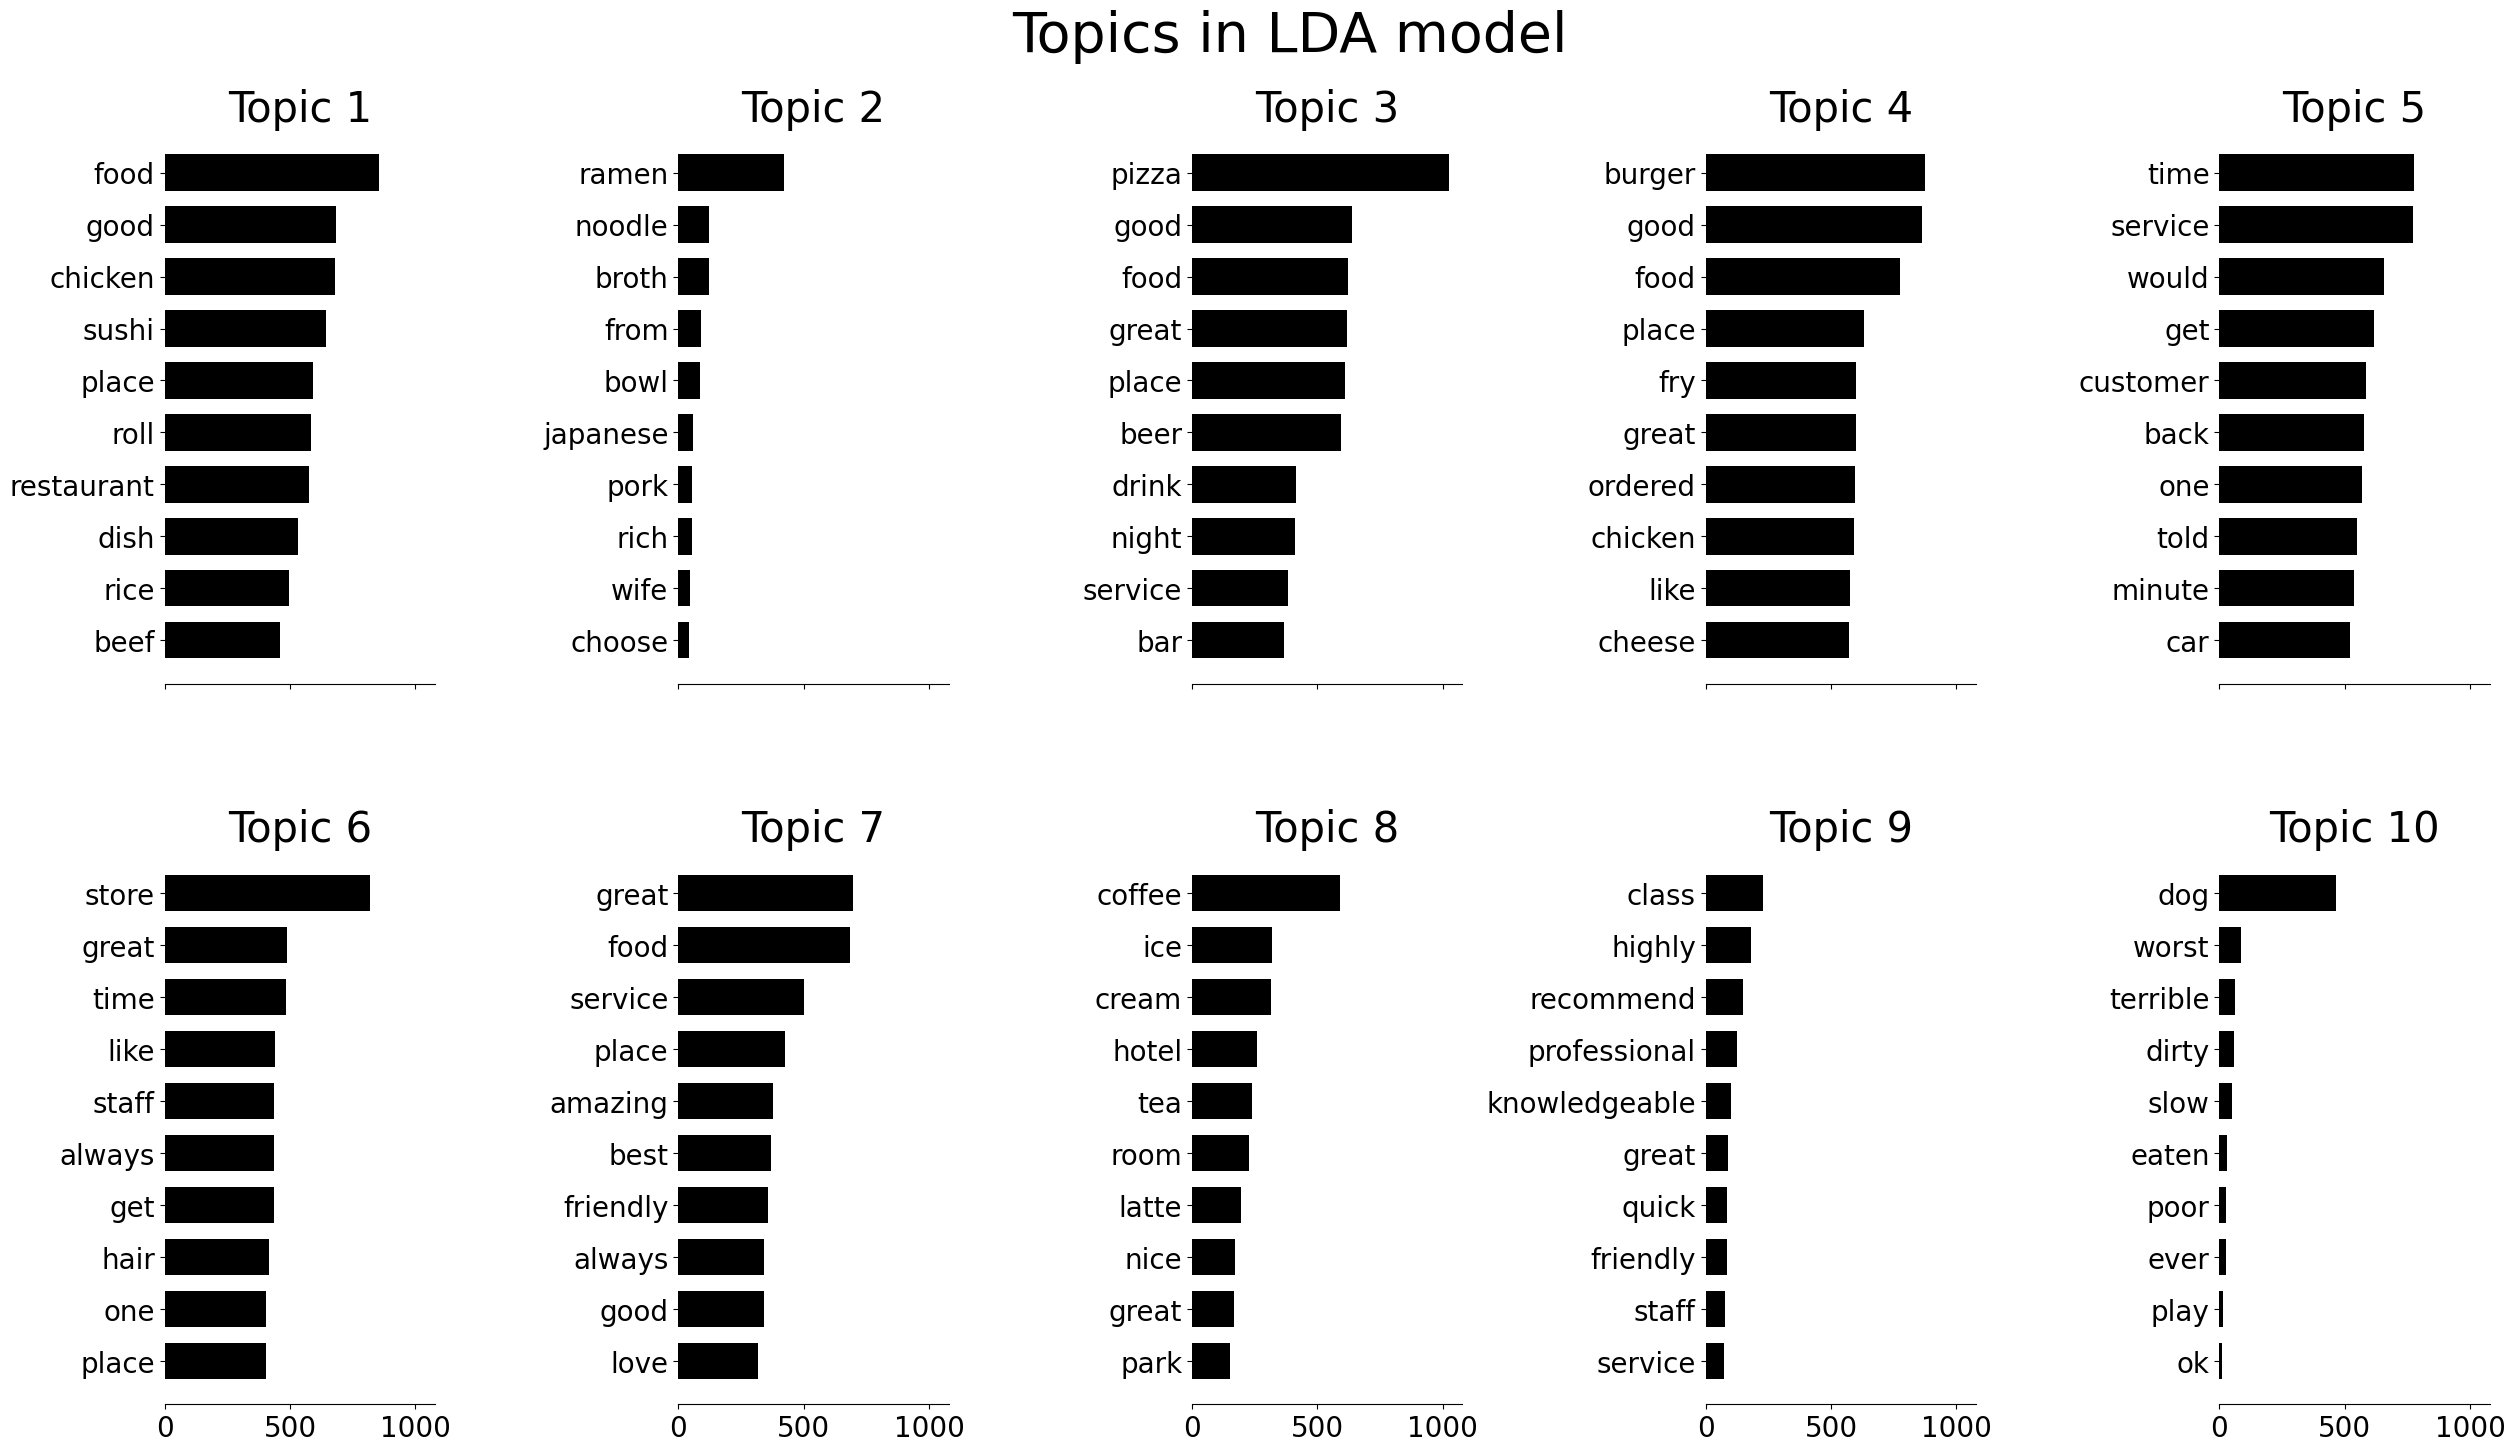

In [89]:
# Run LDA
no_topics=10
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0,
                                n_jobs=8).fit(tf)
# plot top words
no_top_words = 10
plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

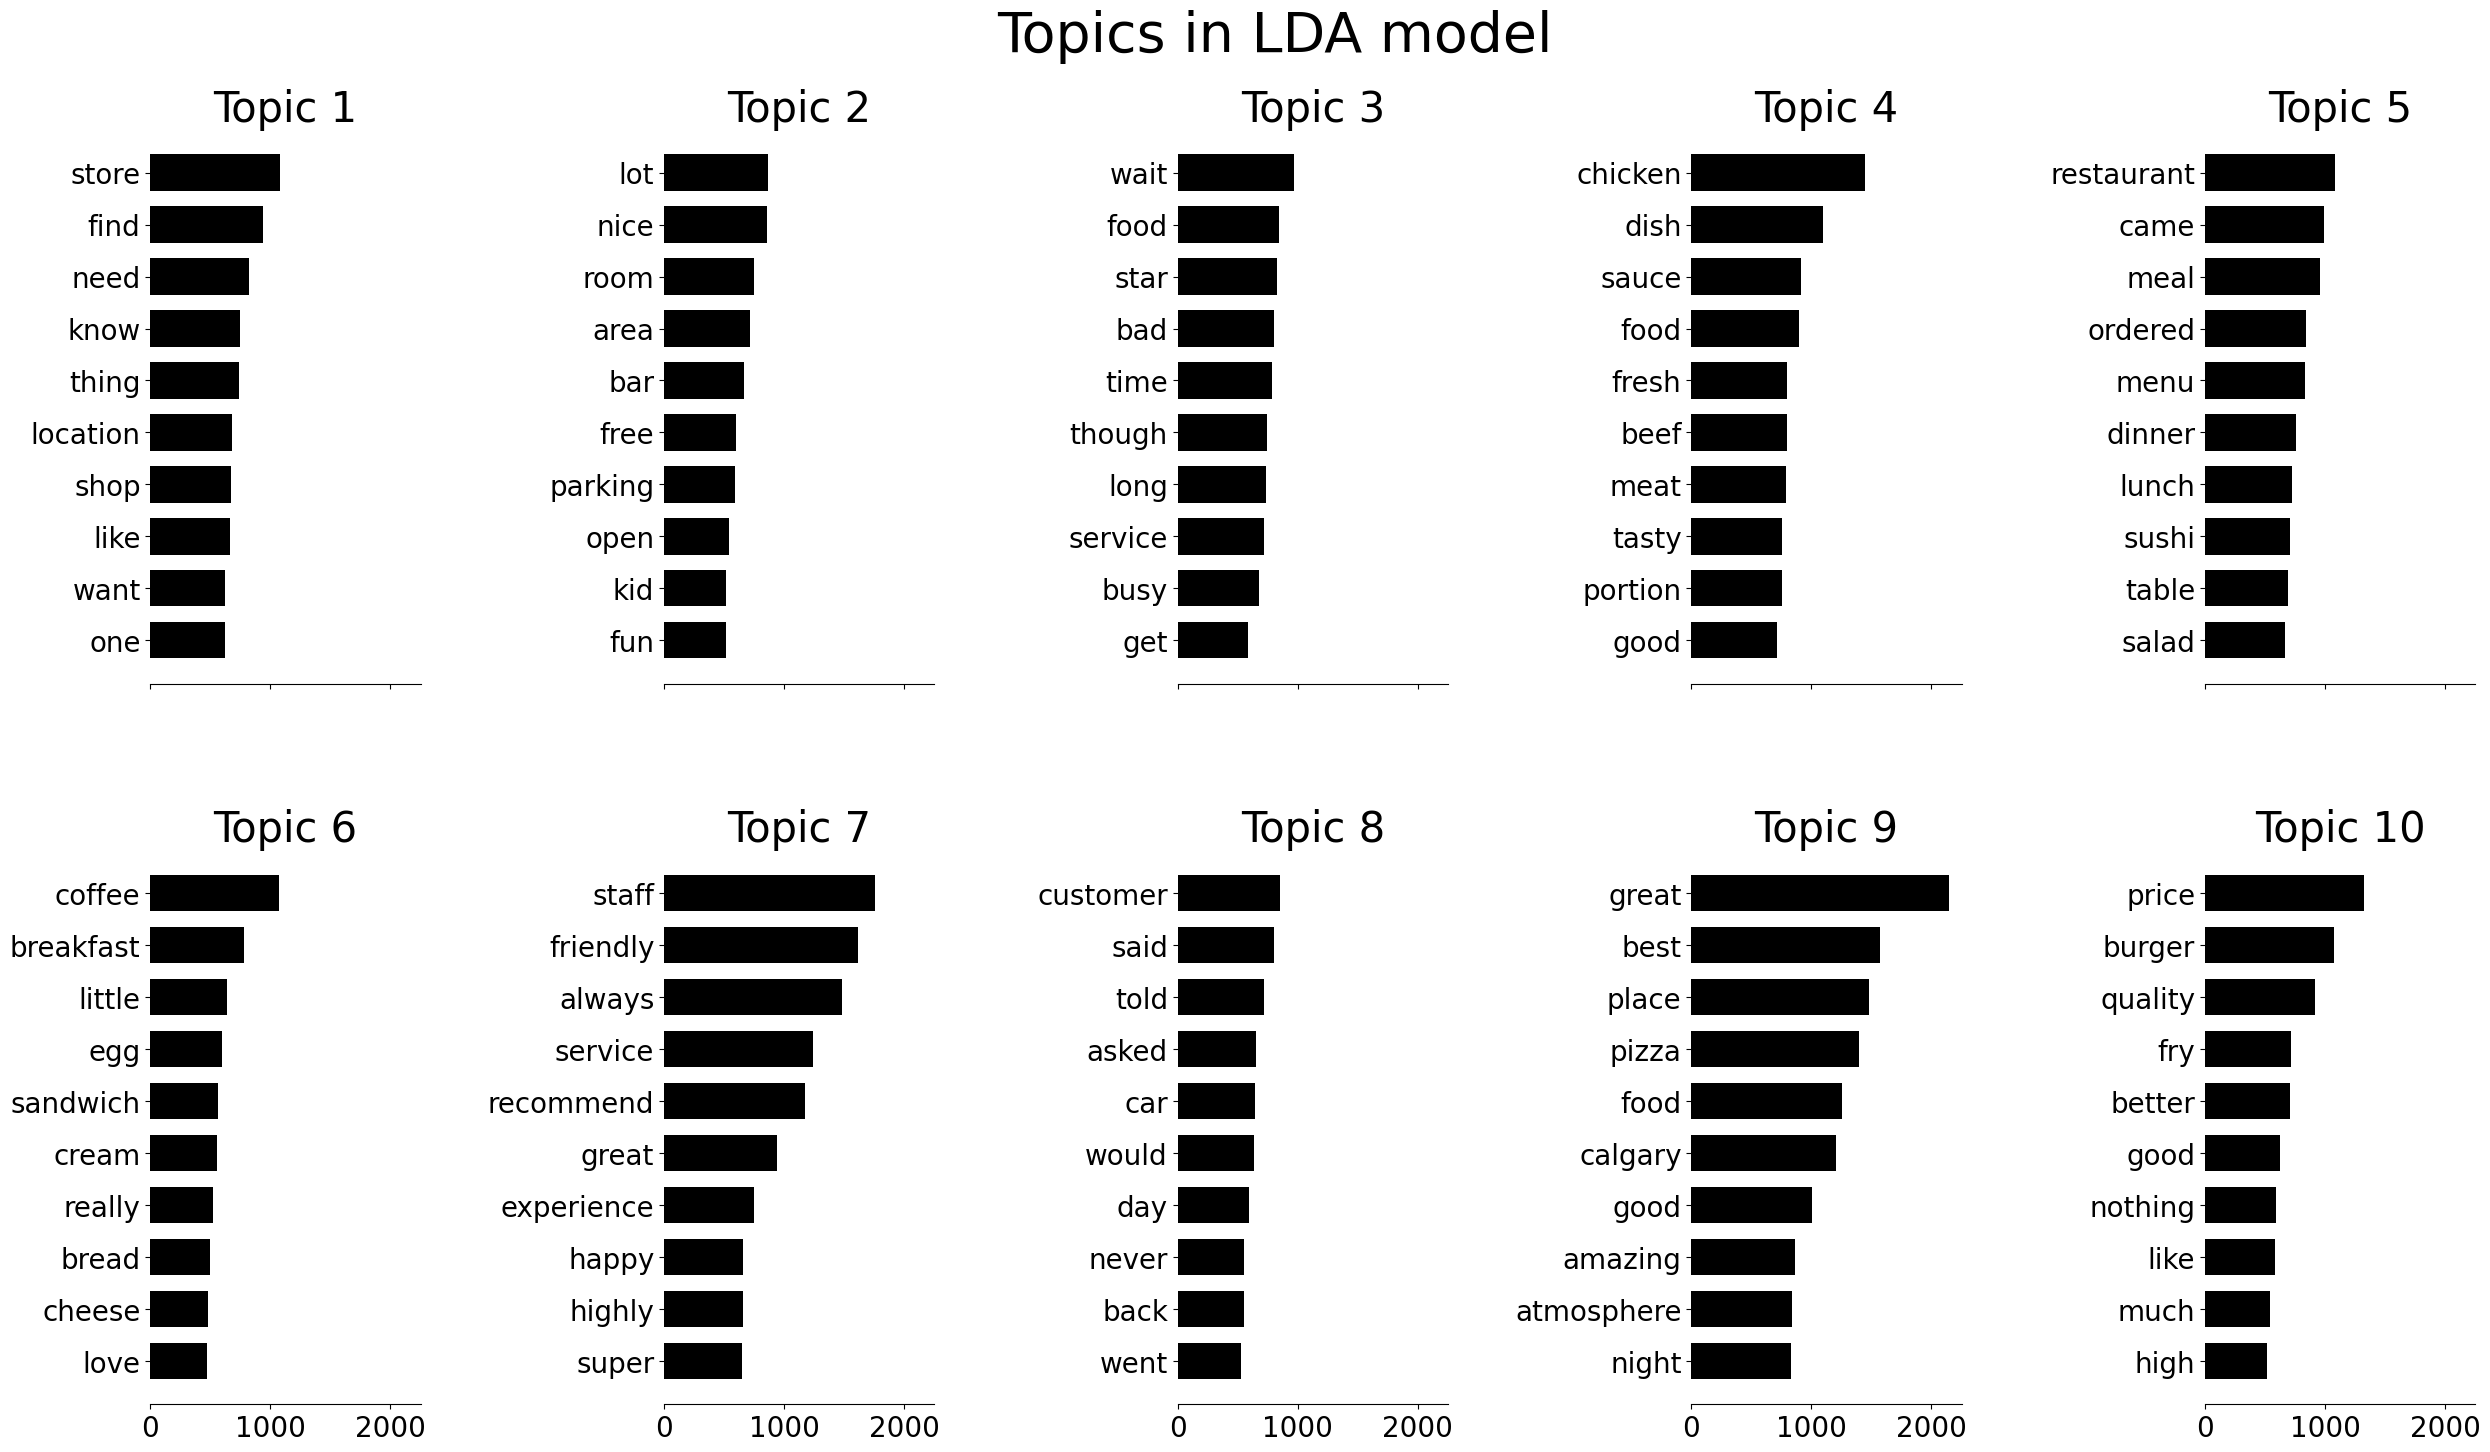

In [85]:
# Run LDA
no_topics=10
alpha= 0.5
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50.,random_state=0,
                                doc_topic_prior=alpha).fit(tf)
# plot top words
no_top_words = 10
plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

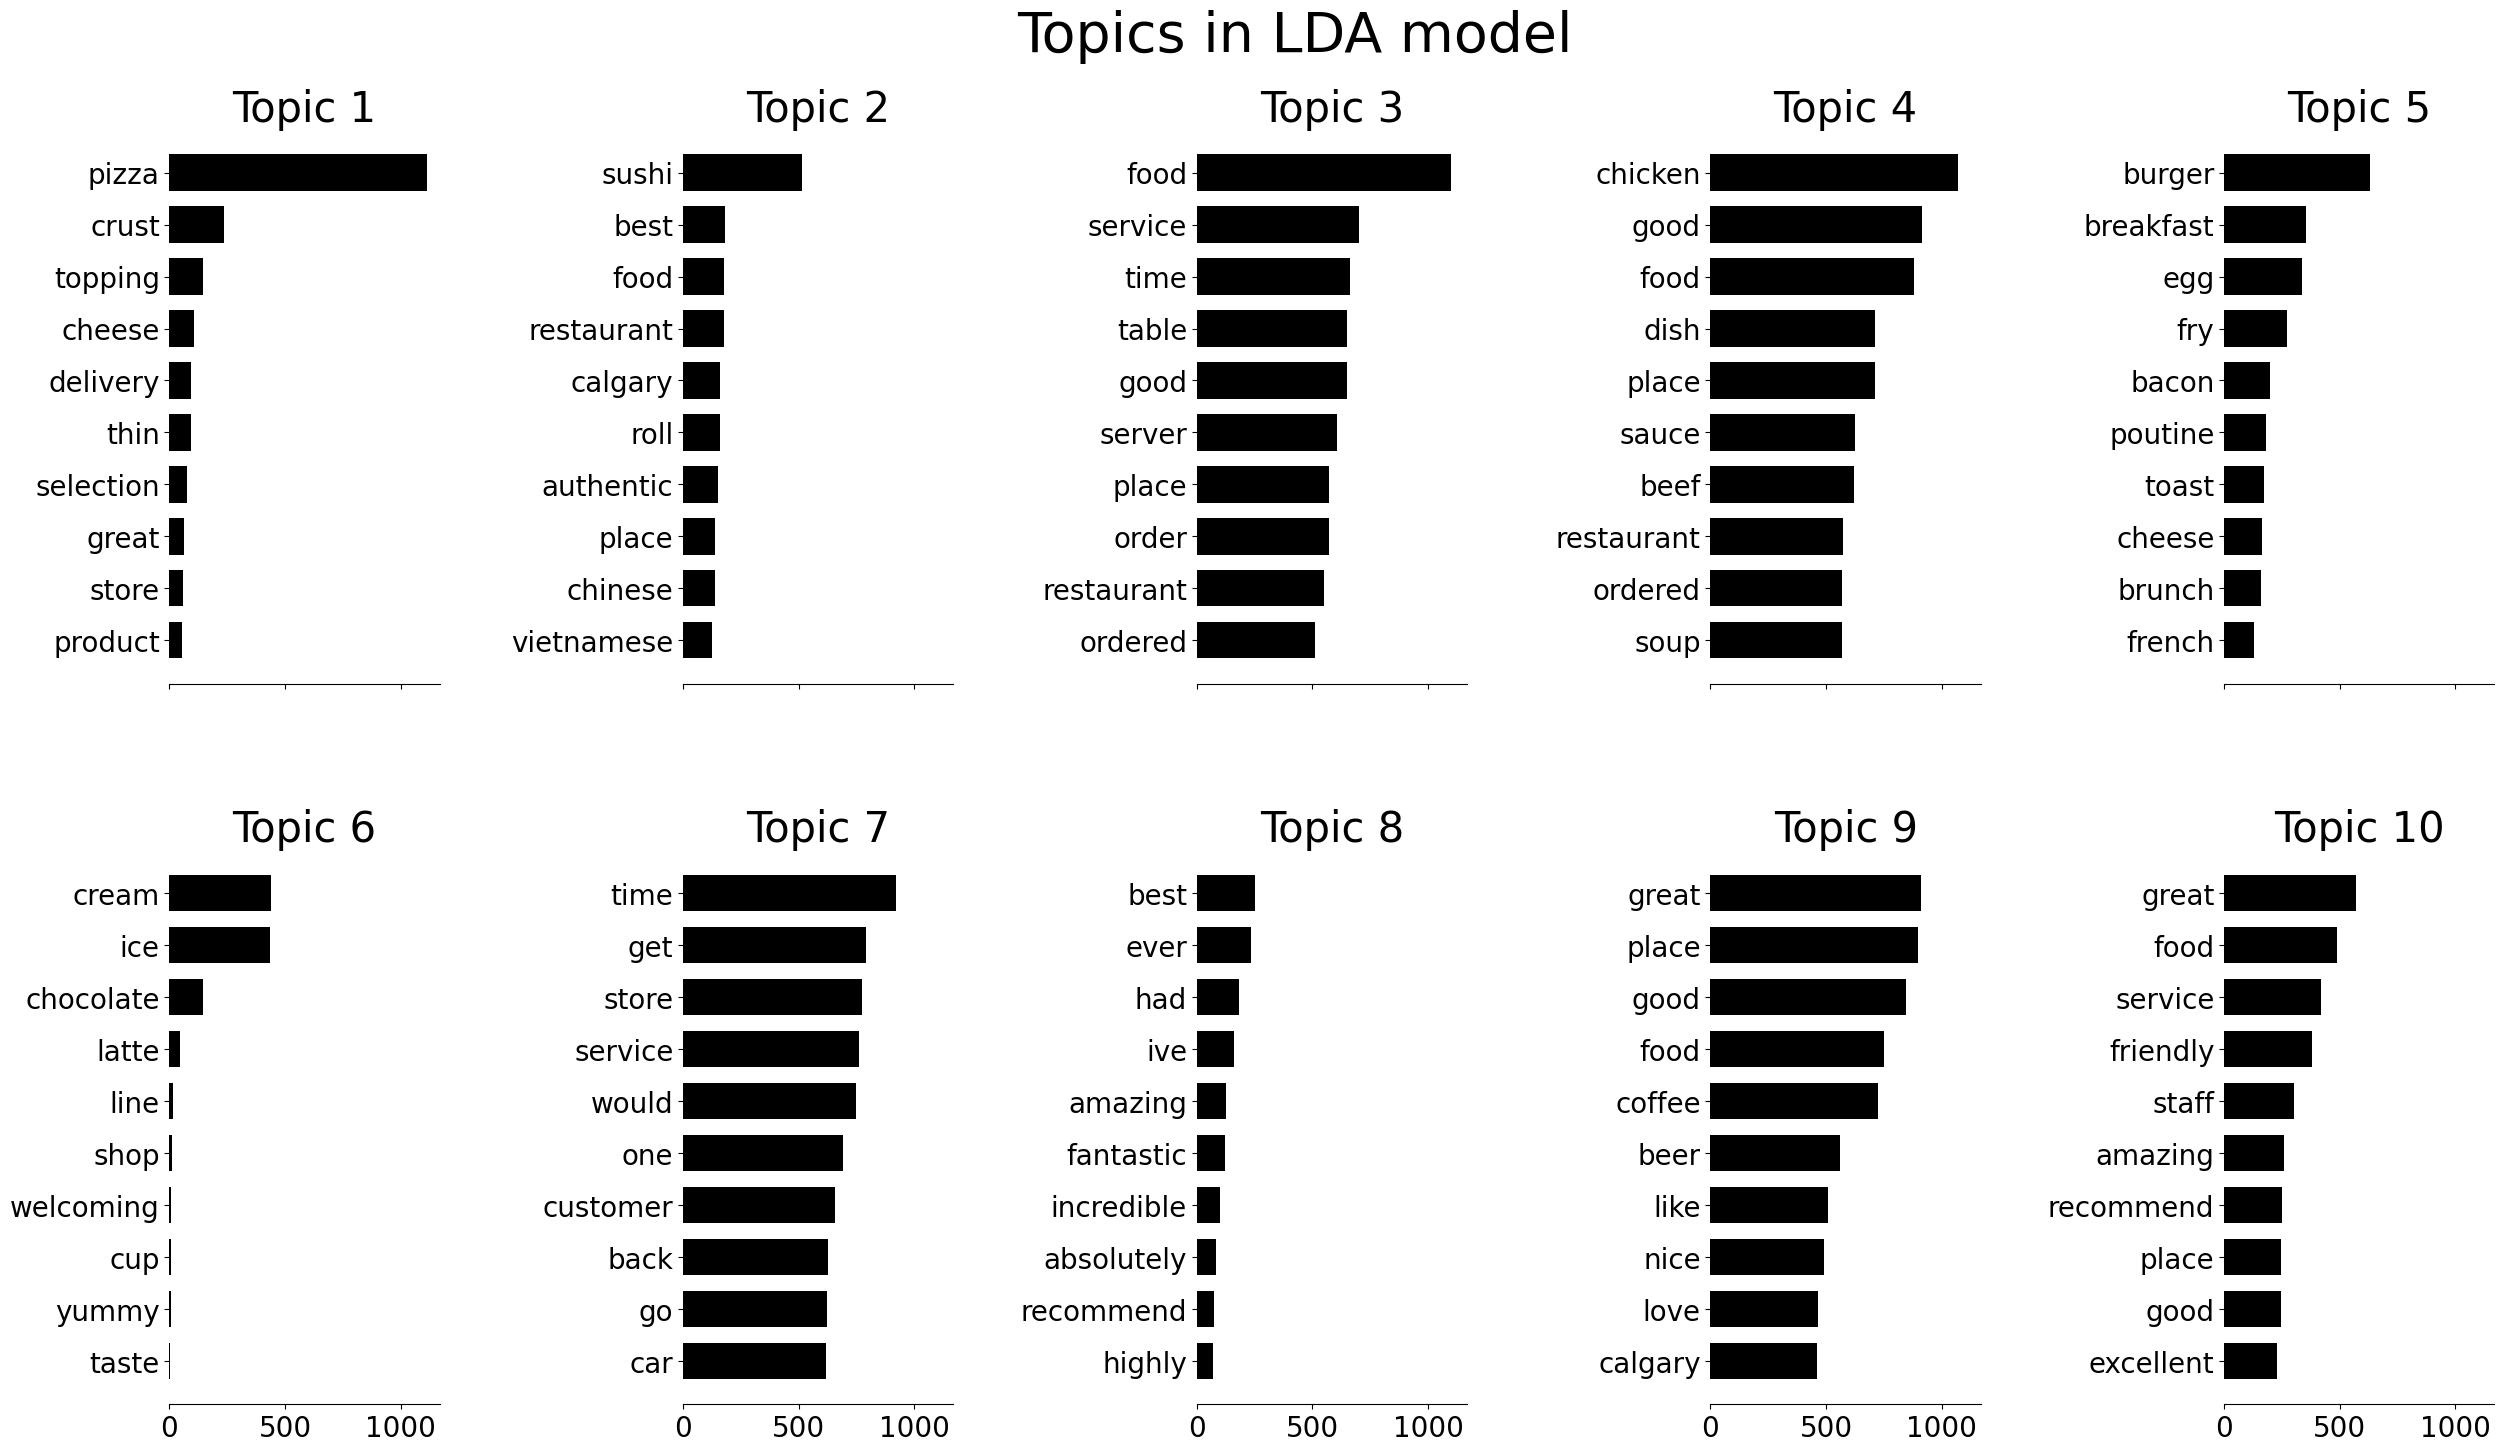

In [86]:
# Run LDA
no_topics=10
eta= 0.1
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50.,random_state=0,
                                topic_word_prior=eta).fit(tf)
# plot top words
no_top_words = 10
plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

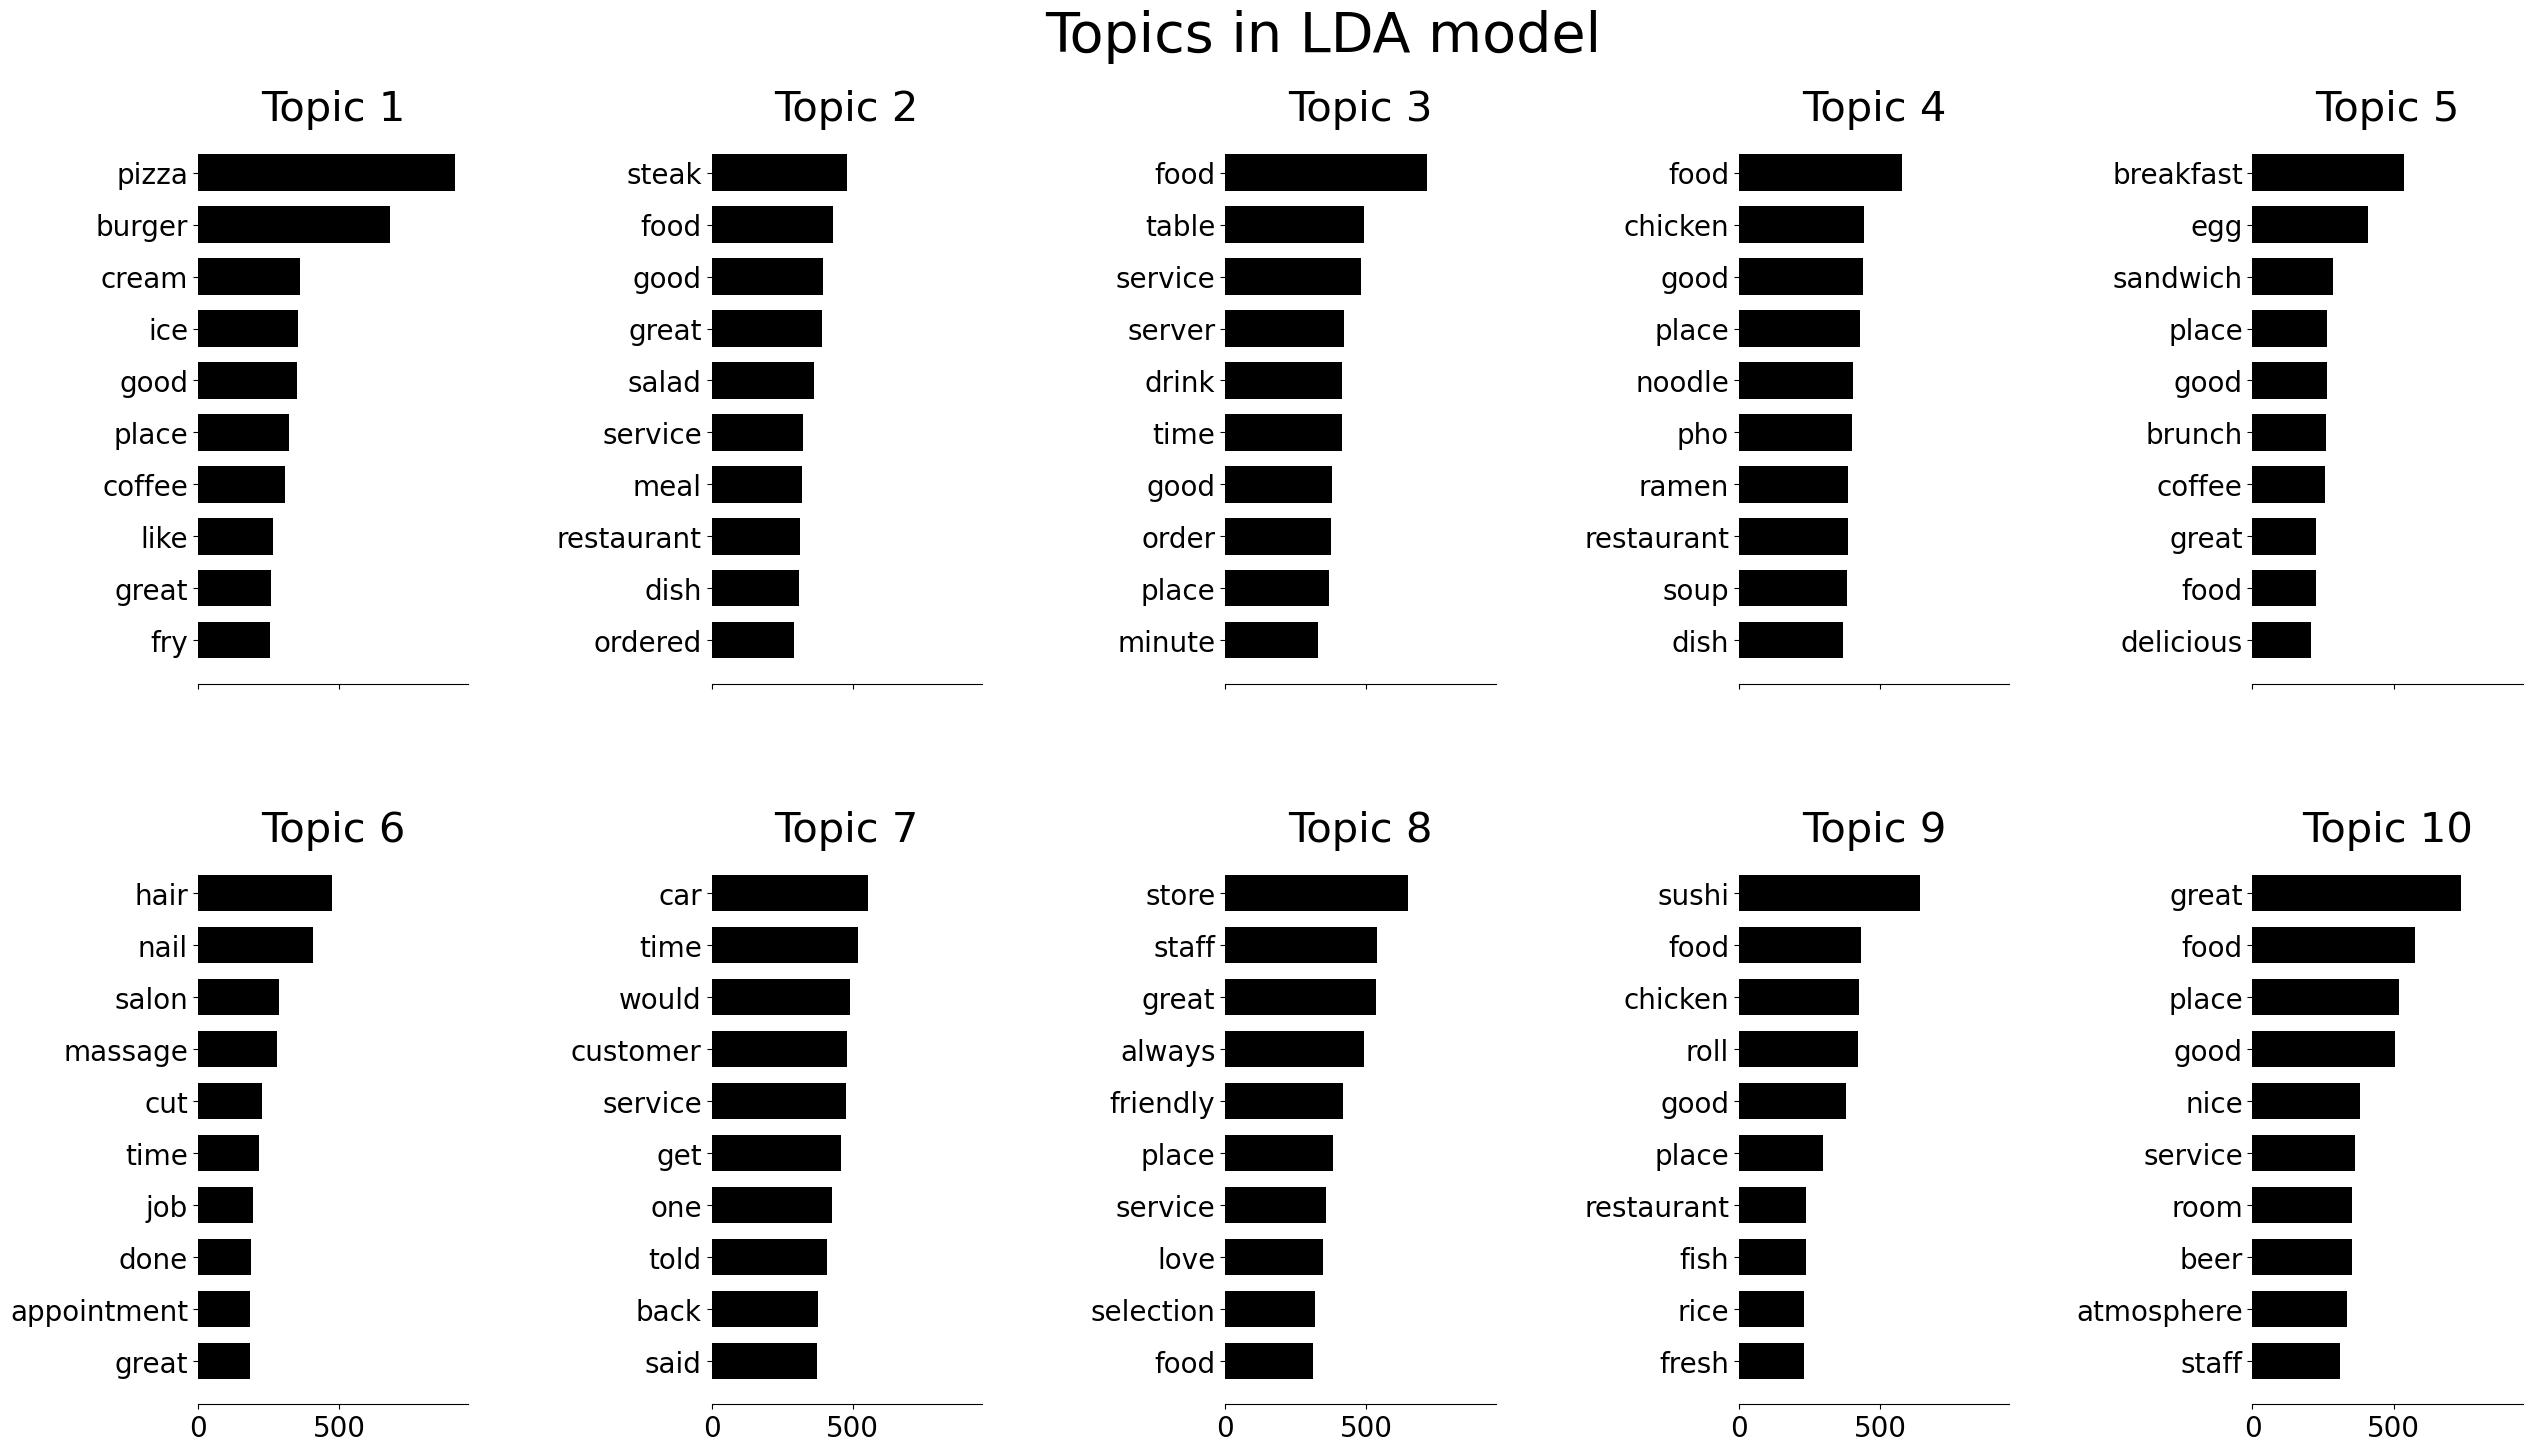

In [16]:
# Run LDA
no_topics=10
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='batch', 
                                learning_offset=50.,random_state=0).fit(tf)
# plot top words
no_top_words = 10
plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

We get the topic distribution of our data from the last model we conducted and create a data frame with topics and probabilities of each review.

In [ ]:
# Get the topic distribution for each document
doc_topics = lda.transform(tf)

# Create a DataFrame to store the topic assignments for each document
doc_topics_df = pd.DataFrame(columns=['Document', 'Assigned Topic', 'Probability'])

# Assign topics to each document and store the results in the DataFrame
for i, doc in enumerate(doc_topics):
    assigned_topic = doc.argmax()
    probability = doc.max()
    doc_topics_df.loc[i] = [data.preprocessed_text.iloc[i], assigned_topic, probability]

# Print the top words for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f'Top words for Topic {topic_idx}:')
    print([tf_feature_names[i] for i in topic.argsort()[:-11:-1]])
    print('\n')

# Evaluate the topic assignments by printing the top documents for each topic
for topic_idx in range(no_topics):
    print(f'Top documents for Topic {topic_idx + 1}:')
    print(doc_topics_df.loc[doc_topics_df['Assigned Topic'] == topic_idx + 1].sort_values('Probability', ascending=False).head(10))
    print('\n')

In [58]:
# Create a new DataFrame to combine the document text, the assigned topics, and the probabilities
output_df = pd.concat([data.preprocessed_text, doc_topics_df[['Assigned Topic', 'Probability']]], axis=1)

# Sort the DataFrame by the assigned topics
output_df = output_df.sort_values('Probability')

# Print the output DataFrame
output_df

,preprocessed_text,Assigned Topic,Probability
55492,place fantastic young lady counter friendly he...,0.0,0.100000
72605,second visit alloy time valentine day menu hus...,0.0,0.100000
75229,staff ownership get effort turning formerly pe...,0.0,0.100000
73690,metropolitan grill certainly seemed happening ...,0.0,0.100000
59463,baya rica top pick coffee area love warm feel ...,0.0,0.100000
...,...,...,...
7542,wish even give star im one complain love see s...,2.0,0.934202
82178,used martin pest control underconcrete frontst...,NaN,NaN
82179,company came home inspected place wrote report...,NaN,NaN
82180,would never recommend anyone purchased home mo...,NaN,NaN


We rename the topics according to the context and plot them. 

In [59]:
topic_titles = ['Fast Food', 'Dinner','Food Service','Asian Food - General','Breakfast & Brunch','Hair & Nail Salon',
                'Car Rental','Stores','Asian Food - Sushi','Food & Hotels']




In [60]:
def plot_top_words_with_titles(model, feature_names, n_top_words, title, rows=2, columns=5):
    fig, axes = plt.subplots(rows, columns, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,color='black')
        ax.set_title(topic_titles[topic_idx],
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
    

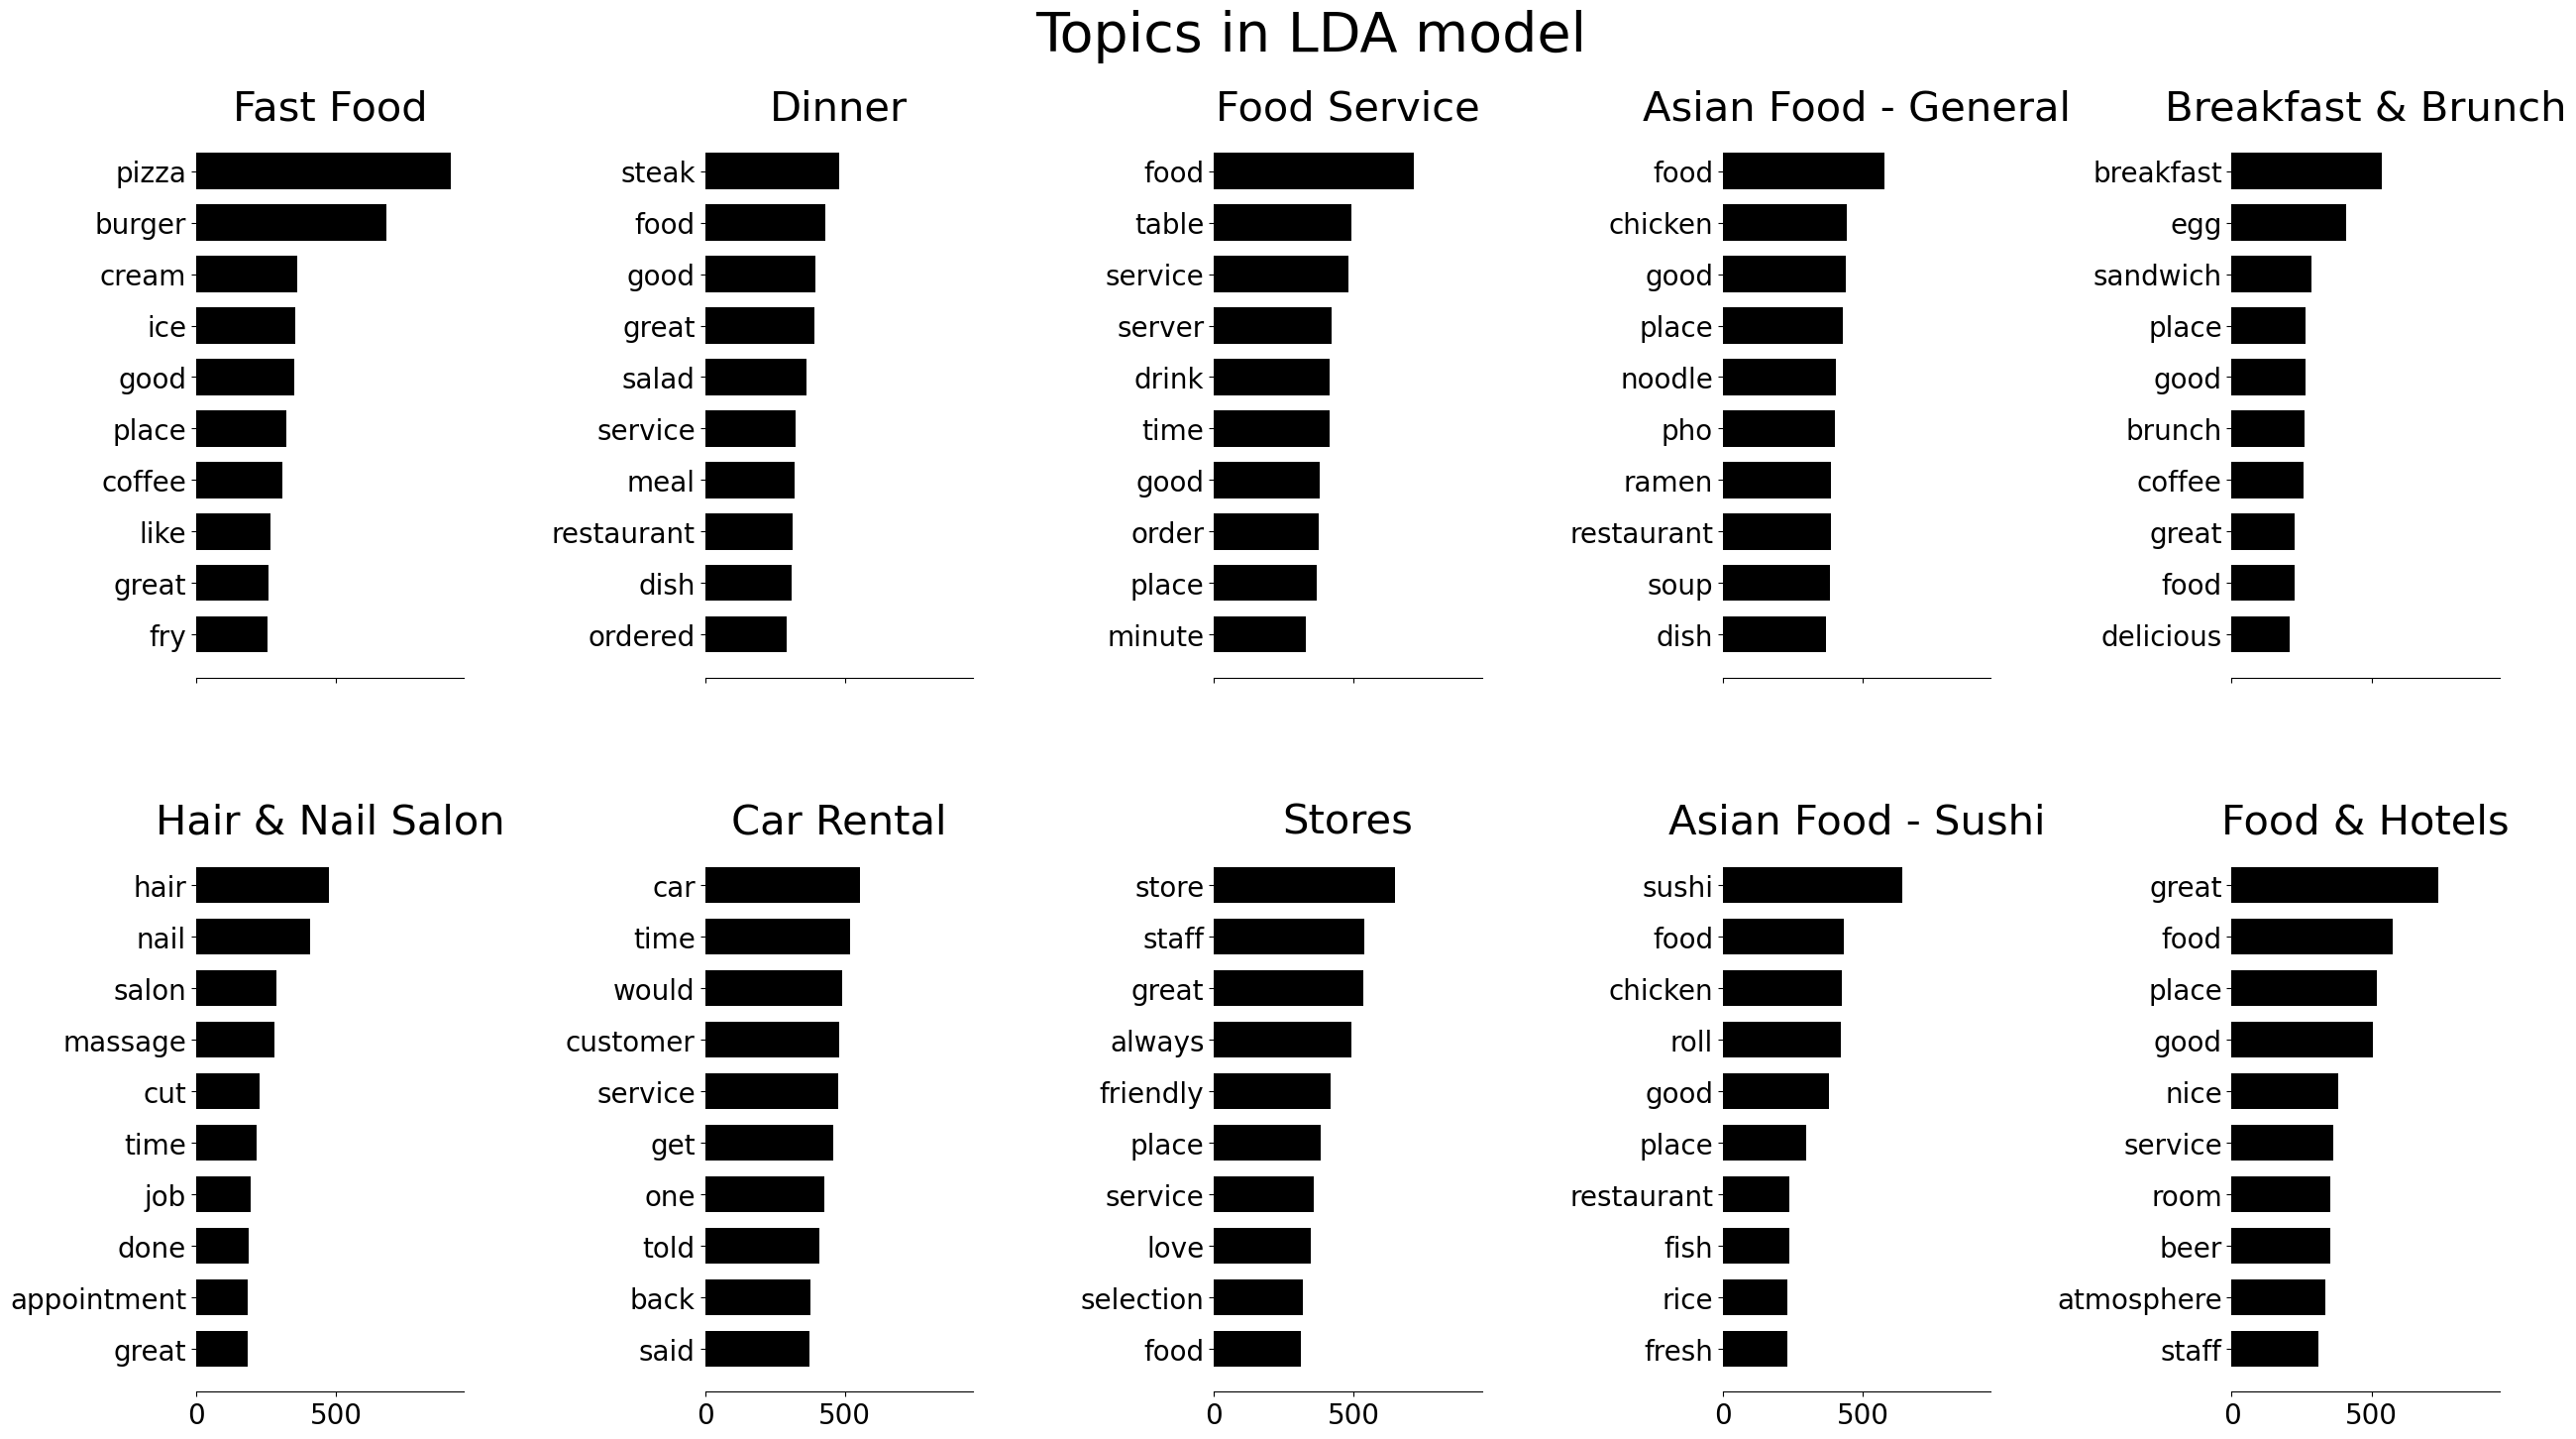

In [61]:
no_top_words = 10
plot_top_words_with_titles(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

## Bibliography

* [1] Sklearn.linear_model.logisticregression, Scikit Learn: Machine Learning in Python. Available at: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html (Accessed: April 18, 2023). 
* [2] 4.2. permutation feature importance, Scikit Learn: Machine Learning in Python. Available at: https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance (Accessed: April 18, 2023). 